In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import statsmodels.api as sm

import scienceplots
plt.style.use(['science', 'notebook', 'grid'])
import seaborn as sns
#sns.set(palette='pastel', font='serif')
#sns.set_style('white')

In [2]:
# Define functions
def studentpdf(epsilon, nu):
    # if nu <= 2: 
    #     return 0
    return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)


def garch(parameters, returns):
    mu, omega, alpha, beta, nu = parameters
    T = len(returns)
    sigma_squared = np.zeros(T)
    sigma_squared[0] = omega / (1 - alpha - beta)
    for t in range(1, T):
        sigma_squared[t] = omega + alpha * (returns[t - 1] - mu) ** 2 + beta * sigma_squared[t - 1]
    return sigma_squared


def asymmetric_garch(parameters, returns):
    mu, omega, alpha_pos, alpha_neg, beta, nu = parameters
    T = len(returns)
    sigma_squared = np.zeros(T)
    initial_divisor = 1 - beta - alpha_pos / 2 - alpha_neg / 2
    sigma_squared[0] = omega / initial_divisor
    for t in range(1, T):
        epsilon_t = (returns[t-1] - mu)
        shock_effect = alpha_pos * (epsilon_t**2) if epsilon_t >= 0 else alpha_neg * (epsilon_t**2)
        sigma_squared[t] = omega + shock_effect + beta * sigma_squared[t-1]
    return sigma_squared


def asymmetric_beta_t_egarch(parameters, returns):
    mu, lam, phi, kappa, kappa_tilde, nu = parameters
    T = len(returns)
    
    u = np.zeros(T)
    v = np.zeros(T)
    epsilon = np.zeros(T)
    lambdas = np.zeros(T)
    sigma = np.zeros(T)
    
    # Initialize starting values
    lambdas[0] = lam
    sigma[0] = np.exp(lam)
    epsilon[0] = (returns[0] - mu) / sigma[0]
    u[0] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[0]**2)) * epsilon[0]**2 - 1)
    v[0] = np.sqrt((nu + 2) * (nu + 3) / (nu + (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon[0]**2)) * epsilon[0]
    
    for t in range(1, T):
        lambdas[t] = lam * (1 - phi) + phi * lambdas[t-1] + kappa * u[t-1] + kappa_tilde * v[t-1]
        sigma[t] = np.exp(lambdas[t])
        epsilon[t] = (returns[t] - mu) / sigma[t]
        u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
        v[t] = np.sqrt((nu + 2) * (nu + 3) / (nu + (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]
    return sigma**2, u, v

def negative_log_likelihood(parameters, returns, model_type):
    """negative log-likelihood function"""
    mu = parameters[0]
    nu = parameters[-1]
    if model_type == 'GARCH':
        sigma_squared = garch(parameters, returns)
    elif model_type == 'Asymmetric GARCH':
        sigma_squared = asymmetric_garch(parameters, returns)
    elif model_type == 'Asymmetric Beta-t-EGARCH' or 'Symmetric Beta-t-EGARCH':
        sigma_squared, _, _ = asymmetric_beta_t_egarch(parameters, returns)
    else:
        raise ValueError("Invalid model type")
    
    epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
    ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(ll)


def optimize_model(model_type, initial_values, bounds, returns):
    """optimization function for different volatility models."""
    result = optimize.minimize(negative_log_likelihood, initial_values, args=(returns, model_type), bounds=bounds, method='SLSQP')
    return result


def plot_results(dates, returns, sigma_squared, model_name):
    plt.figure(figsize=(12, 6), dpi=300)
    plt.plot(dates, returns, 'k', label='Returns')
    plt.plot(dates, np.sqrt(sigma_squared), label=f'Estimated $\hat{{\sigma}}_{{t|t-1}}$ from {model_name} model')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.title(f'Returns and Estimated Volatility - {model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_nic(epsilon, nic, model_name):
    plt.figure(figsize=(10, 5), dpi=300)
    plt.scatter(epsilon, nic, alpha=0.7)
    plt.xlabel('Implied residuals $\epsilon_t$')
    plt.ylabel('NIC')
    plt.title(f'News Impact Curve of the {model_name}')
    plt.grid(True) 
    plt.tight_layout()  
    plt.show()


def target_variable1(returns, d):
    T = len(returns) - d
    TV = np.zeros(T)
    for t in range(T):
        TV[t] = np.sum(returns[t+1:t+1+d]**2)
    return TV


def garch_forecast(parameters, returns, d):
    mu, omega, alpha, beta, nu = parameters
    sigma_squared = garch(parameters, returns)
    unconditional_var = omega / (1 - alpha - beta)
    d_day_forecast = unconditional_var + (alpha + beta)**(d-1) * (sigma_squared[1:] - unconditional_var)
    return d_day_forecast


def PVolGARCH(h, parameters, returns):
    mu, omega, alpha_pos, alpha_neg, beta, nu = parameters
    T = len(returns)
    sigma_squared = asymmetric_garch(parameters, returns)
    unconditional_var = omega / (1 - alpha_pos / 2 - alpha_neg / 2 - beta)
    predictions = h * (mu**2 + unconditional_var) + (1 - (alpha_pos / 2 + alpha_neg / 2 + beta)**h) / (1 - alpha_pos / 2 - alpha_neg / 2 - beta) * (sigma_squared[1:T - h + 1] - unconditional_var)
    return predictions


def PVolBeta_t_GARCH(h, parameters, returns):
    """
    Compute the predicted volatility (PVol) over an h-day horizon using the Beta-t-EGARCH model.

    Parameters:
    - h: Integer, the prediction horizon.
    - parameters: List of model parameters [mu, lam, phi, kappa, kappa_tilde, nu].
    - returns: Series or array of asset returns.

    Returns:
    - pvol: Array of predicted volatilities over the h-day horizon.
    """
    mu, lam, phi, kappa, kappa_tilde, nu = parameters
    T = len(returns)
    pvol = np.zeros(T - h + 1)
    
    sigma_squared, u, v = asymmetric_beta_t_egarch(parameters, returns)
    
    for t in range(T - h):
        term1 = h * mu ** 2
        term2 = 0
        for d in range(1, h + 1):
            term2 += np.exp(
                            2 * lam + 2 * phi**(d - 1) * (np.log(np.sqrt(sigma_squared[t + 1])) - lam) +
                            2 * (kappa ** 2 + kappa_tilde ** 2) * (1 - phi ** (2 * (d - 1))) / (1 - phi ** 2)
            )
        pvol[t] = term1 + term2
    return pvol


def mincer_zarnowitz(actuals, forecasts):
    # Add a constant to the independent variables matrix (for the intercept term)
    forecasts_sm = sm.add_constant(forecasts)
    model = sm.OLS(actuals, forecasts_sm)
    results = model.fit()
    return results

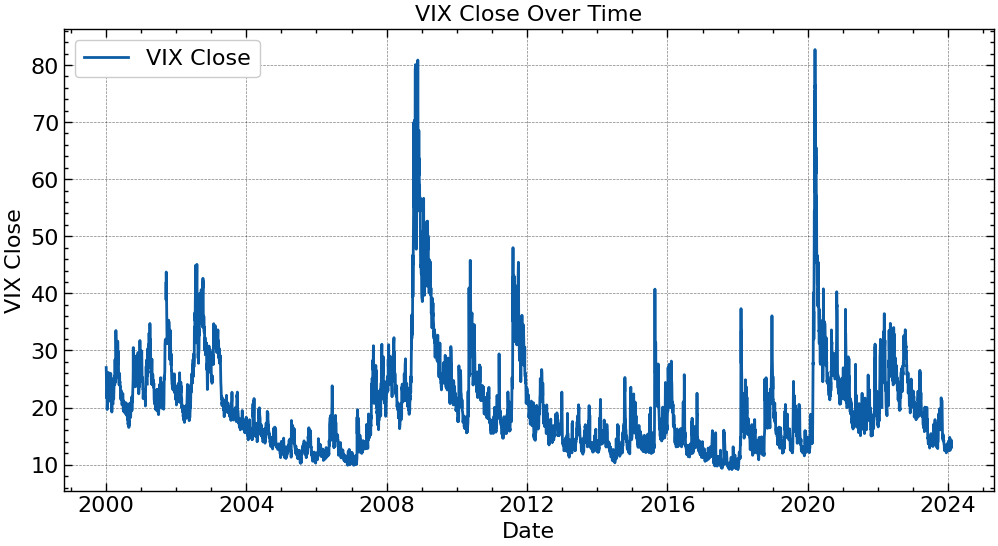

In [3]:
# Read data
data = pd.read_excel('data.xlsx', index_col='date', parse_dates=True)
returns = data['close-to-close log  return'].values
dates = pd.to_datetime(data.index, format='%Y%m%d')

# Plot VIX
plt.figure(figsize=(12, 6))
plt.plot(data['VIX close'], label='VIX Close')
plt.legend()
plt.title('VIX Close Over Time')
plt.xlabel('Date')
plt.ylabel('VIX Close')
plt.show()


# Symmetric GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: divide by zero encountered in divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: invalid value encountered in multiply
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:69: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c

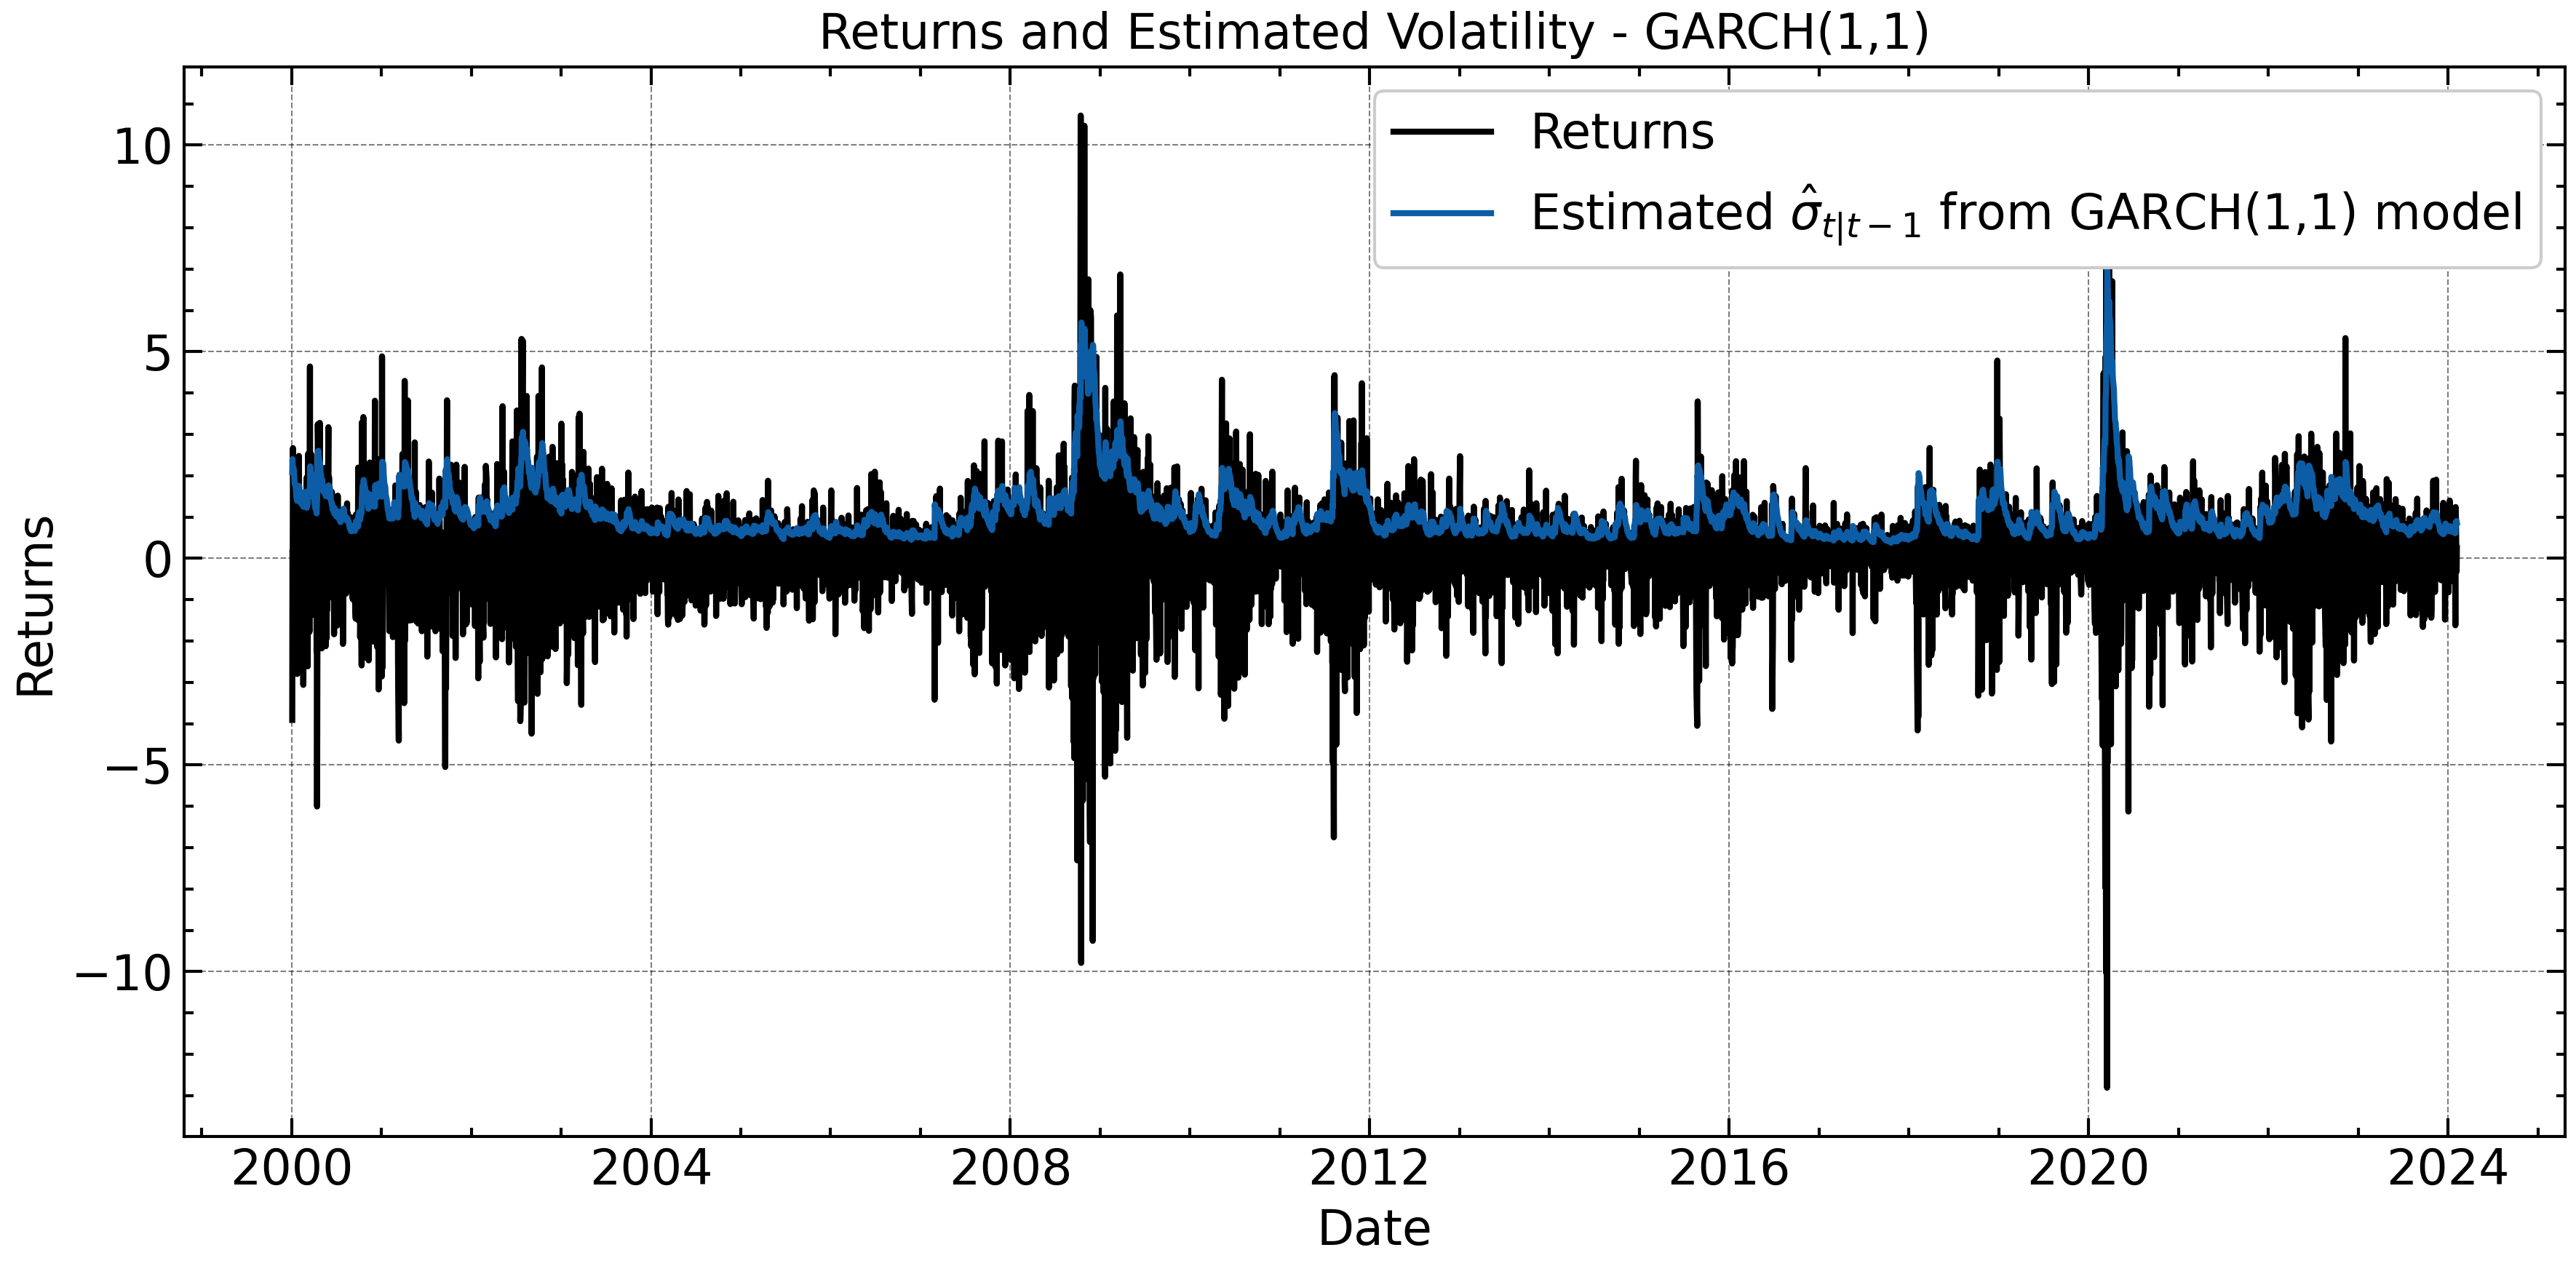

Optimization Successful: Yes
Estimated Parameters:
  mu    : 0.076
  omega : 0.013
  alpha : 0.121
  beta  : 0.876
  nu    : 6.470
Log-Likelihood: -8211.3


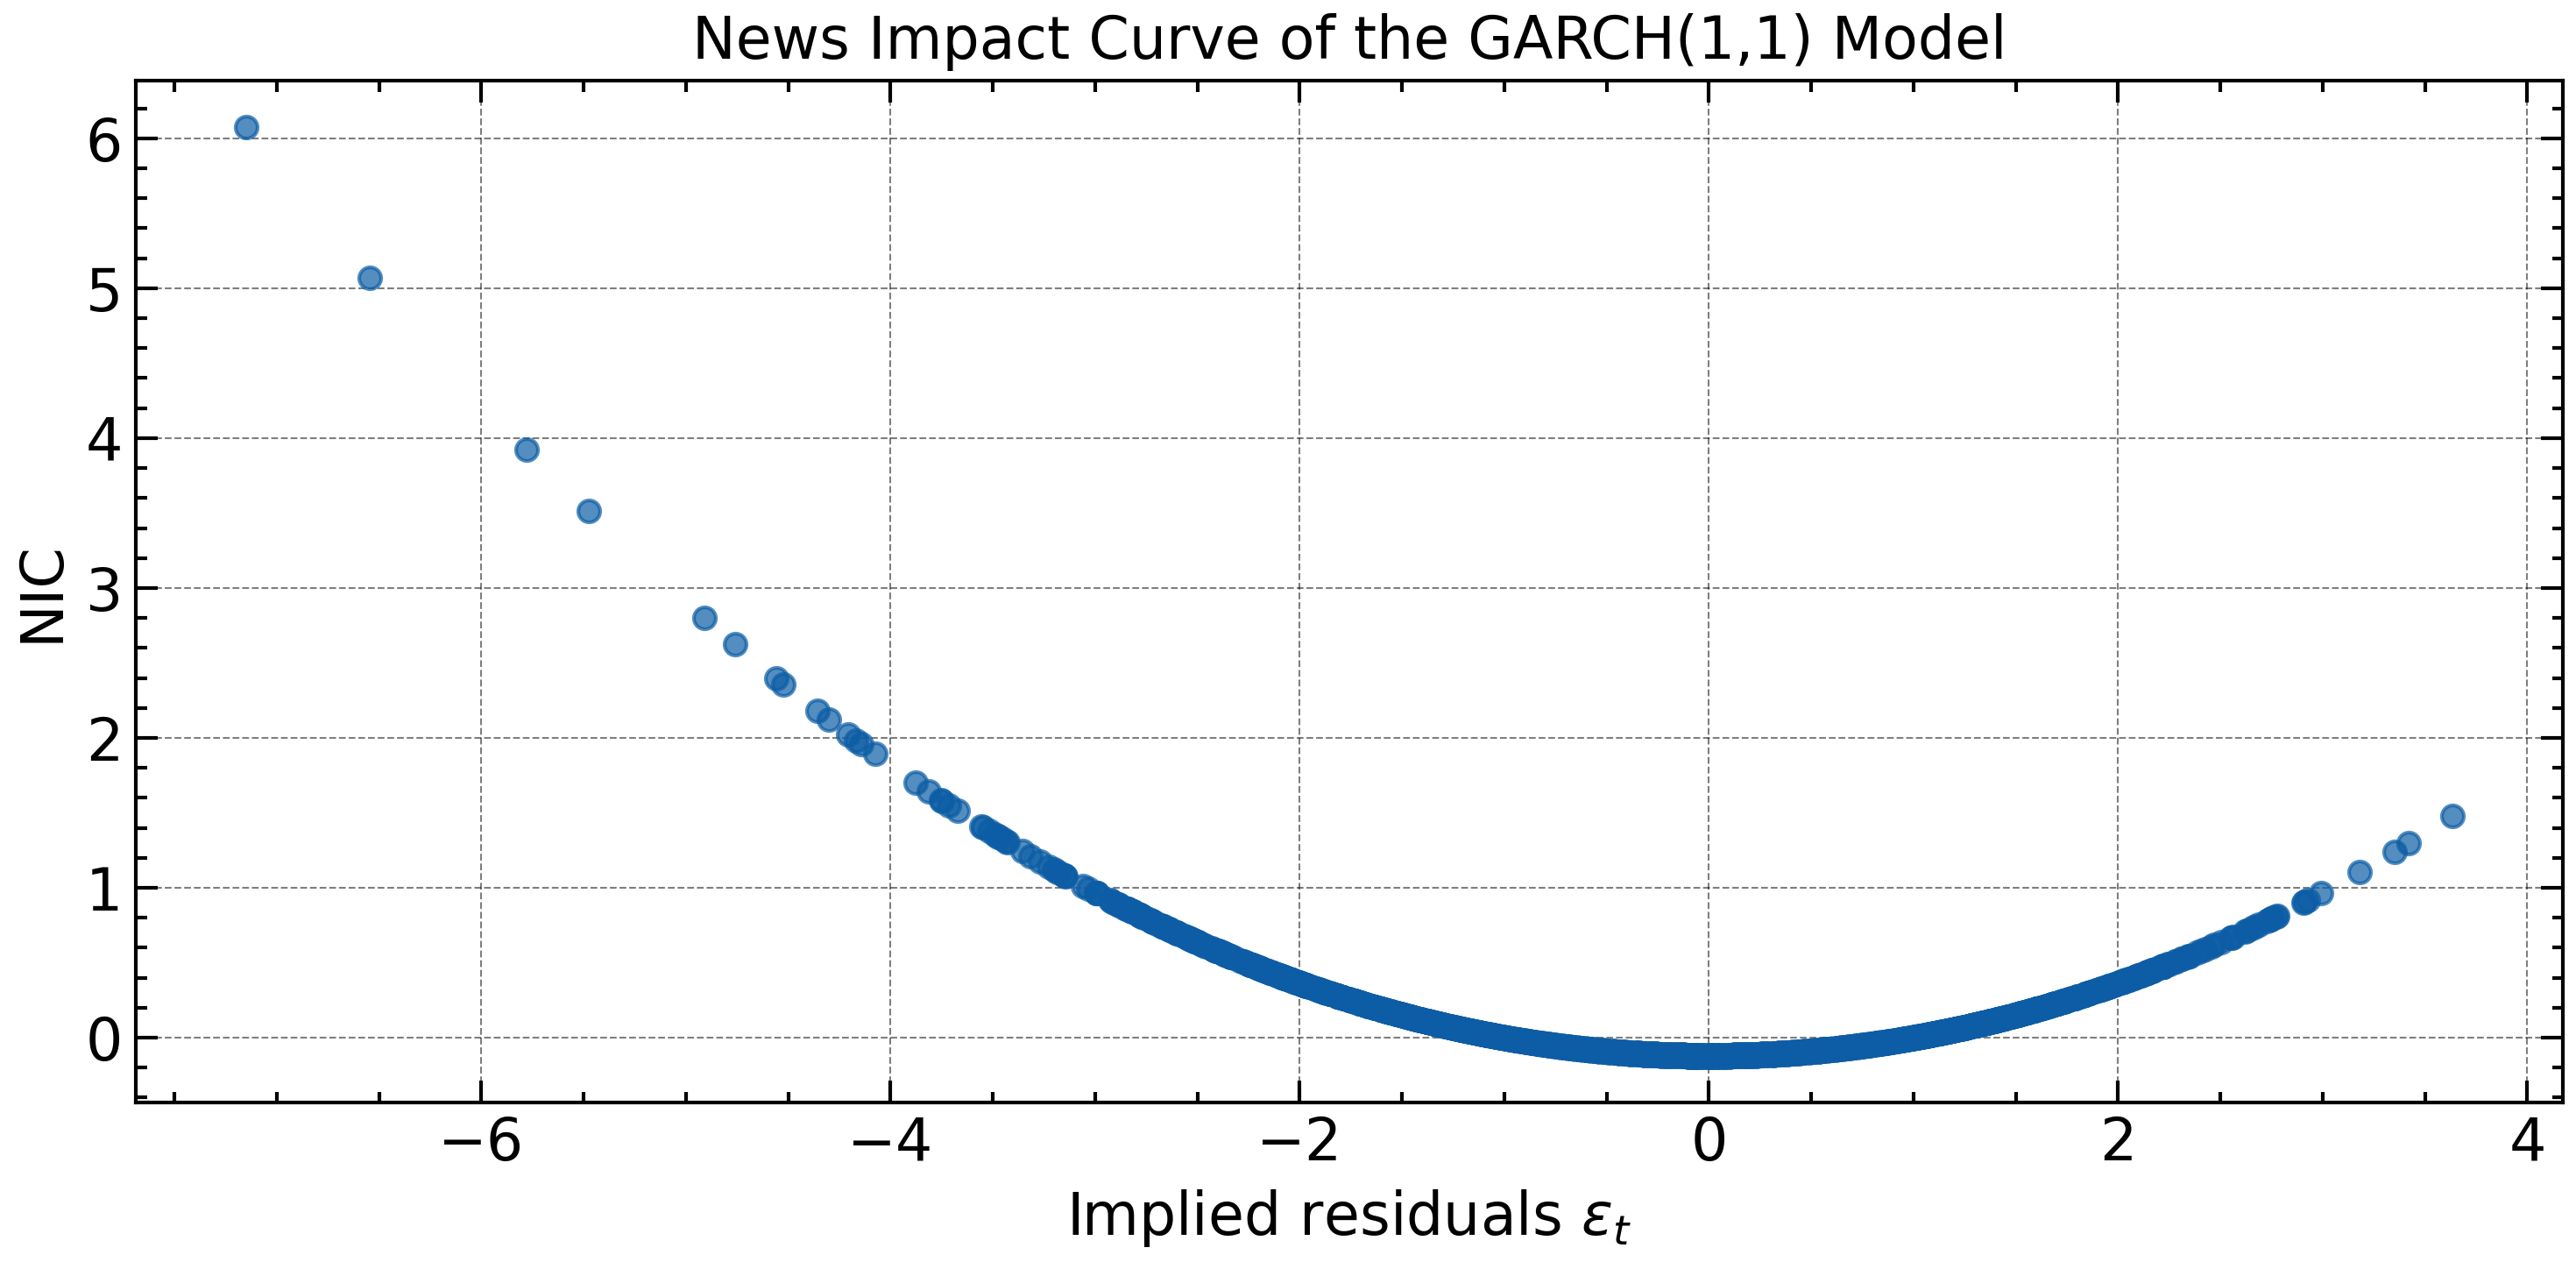

In [4]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize_model('GARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat, beta_hat, nu_hat = result.x
log_likelihood = -result.fun
sigma_squared = garch(result.x, returns)

plot_results(dates, returns, sigma_squared, 'GARCH(1,1)')

print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu    : {mu_hat:.3f}")
print(f"  omega : {omega_hat:.3f}")
print(f"  alpha : {alpha_hat:.3f}")
print(f"  beta  : {beta_hat:.3f}")
print(f"  nu    : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

conditional_var = garch(result.x, returns)
epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = alpha_hat * (epsilon**2 * (epsilon >= 0) - 1/2) + alpha_hat * (epsilon**2 * (epsilon < 0) - 1/2)
plot_nic(epsilon, nic, 'GARCH(1,1) Model')

# Asymmetric GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: divide by zero encountered in divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: invalid value encountered in multiply
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:69: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c

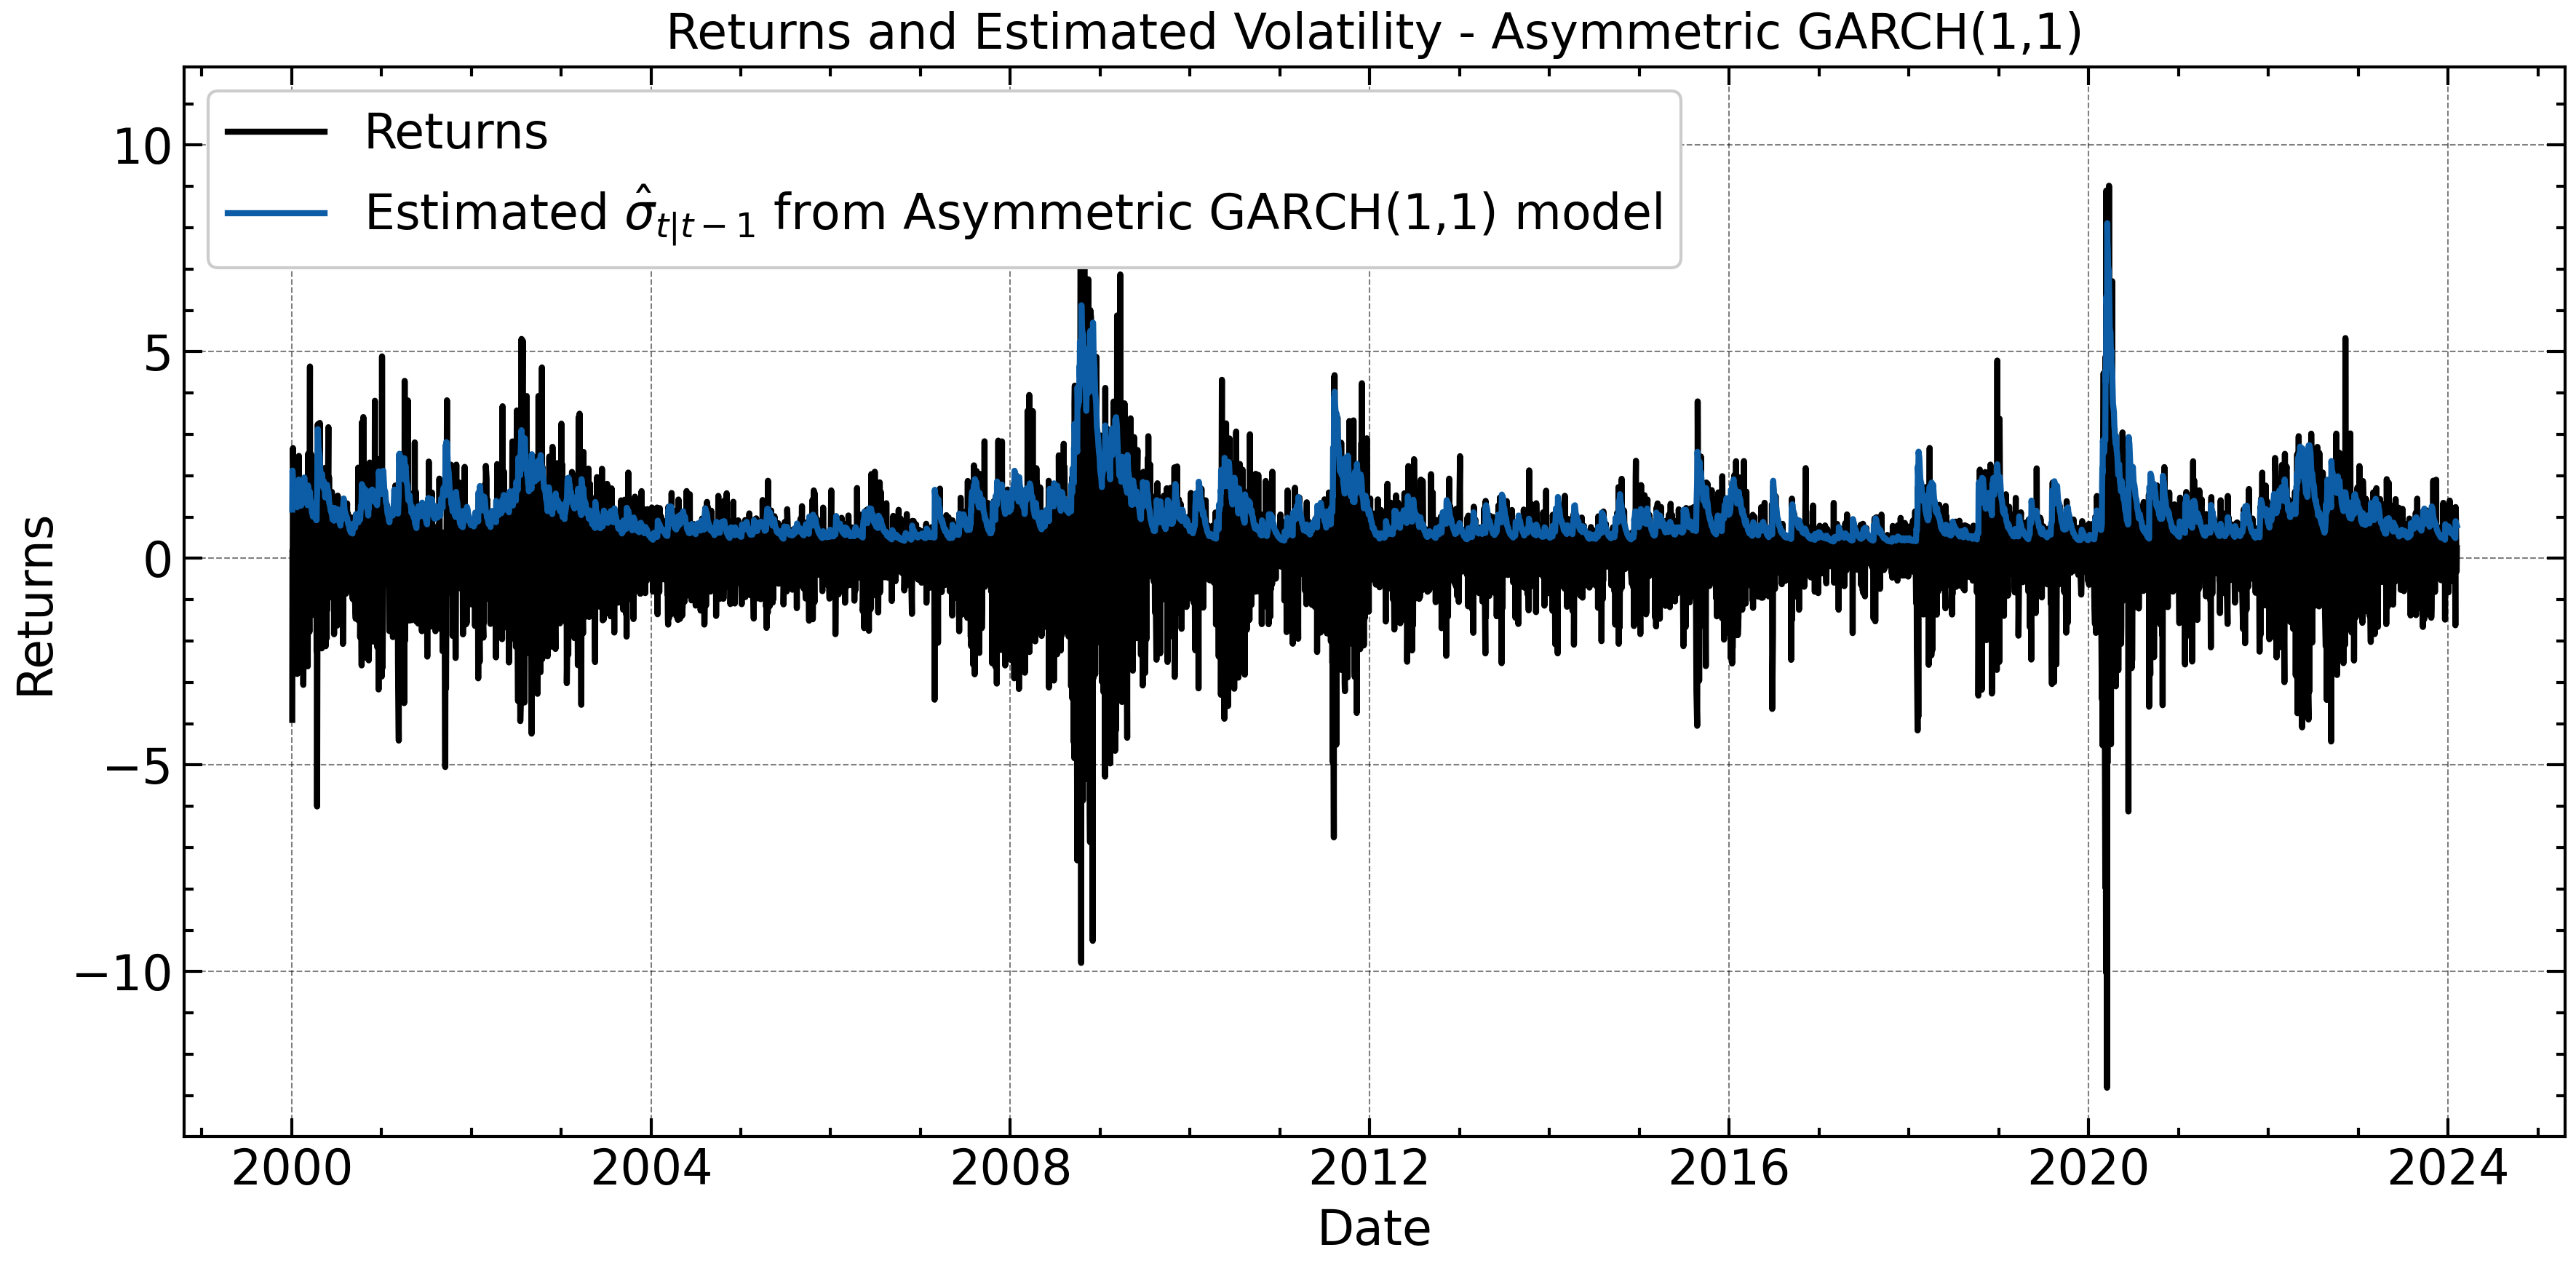

Optimization Successful: Yes
Estimated Parameters:
  mu          : 0.046
  omega       : 0.017
  alpha_pos   : 0.000
  alpha_neg   : 0.208
  beta        : 0.884
  nu          : 6.893
Log-Likelihood: -8111.4


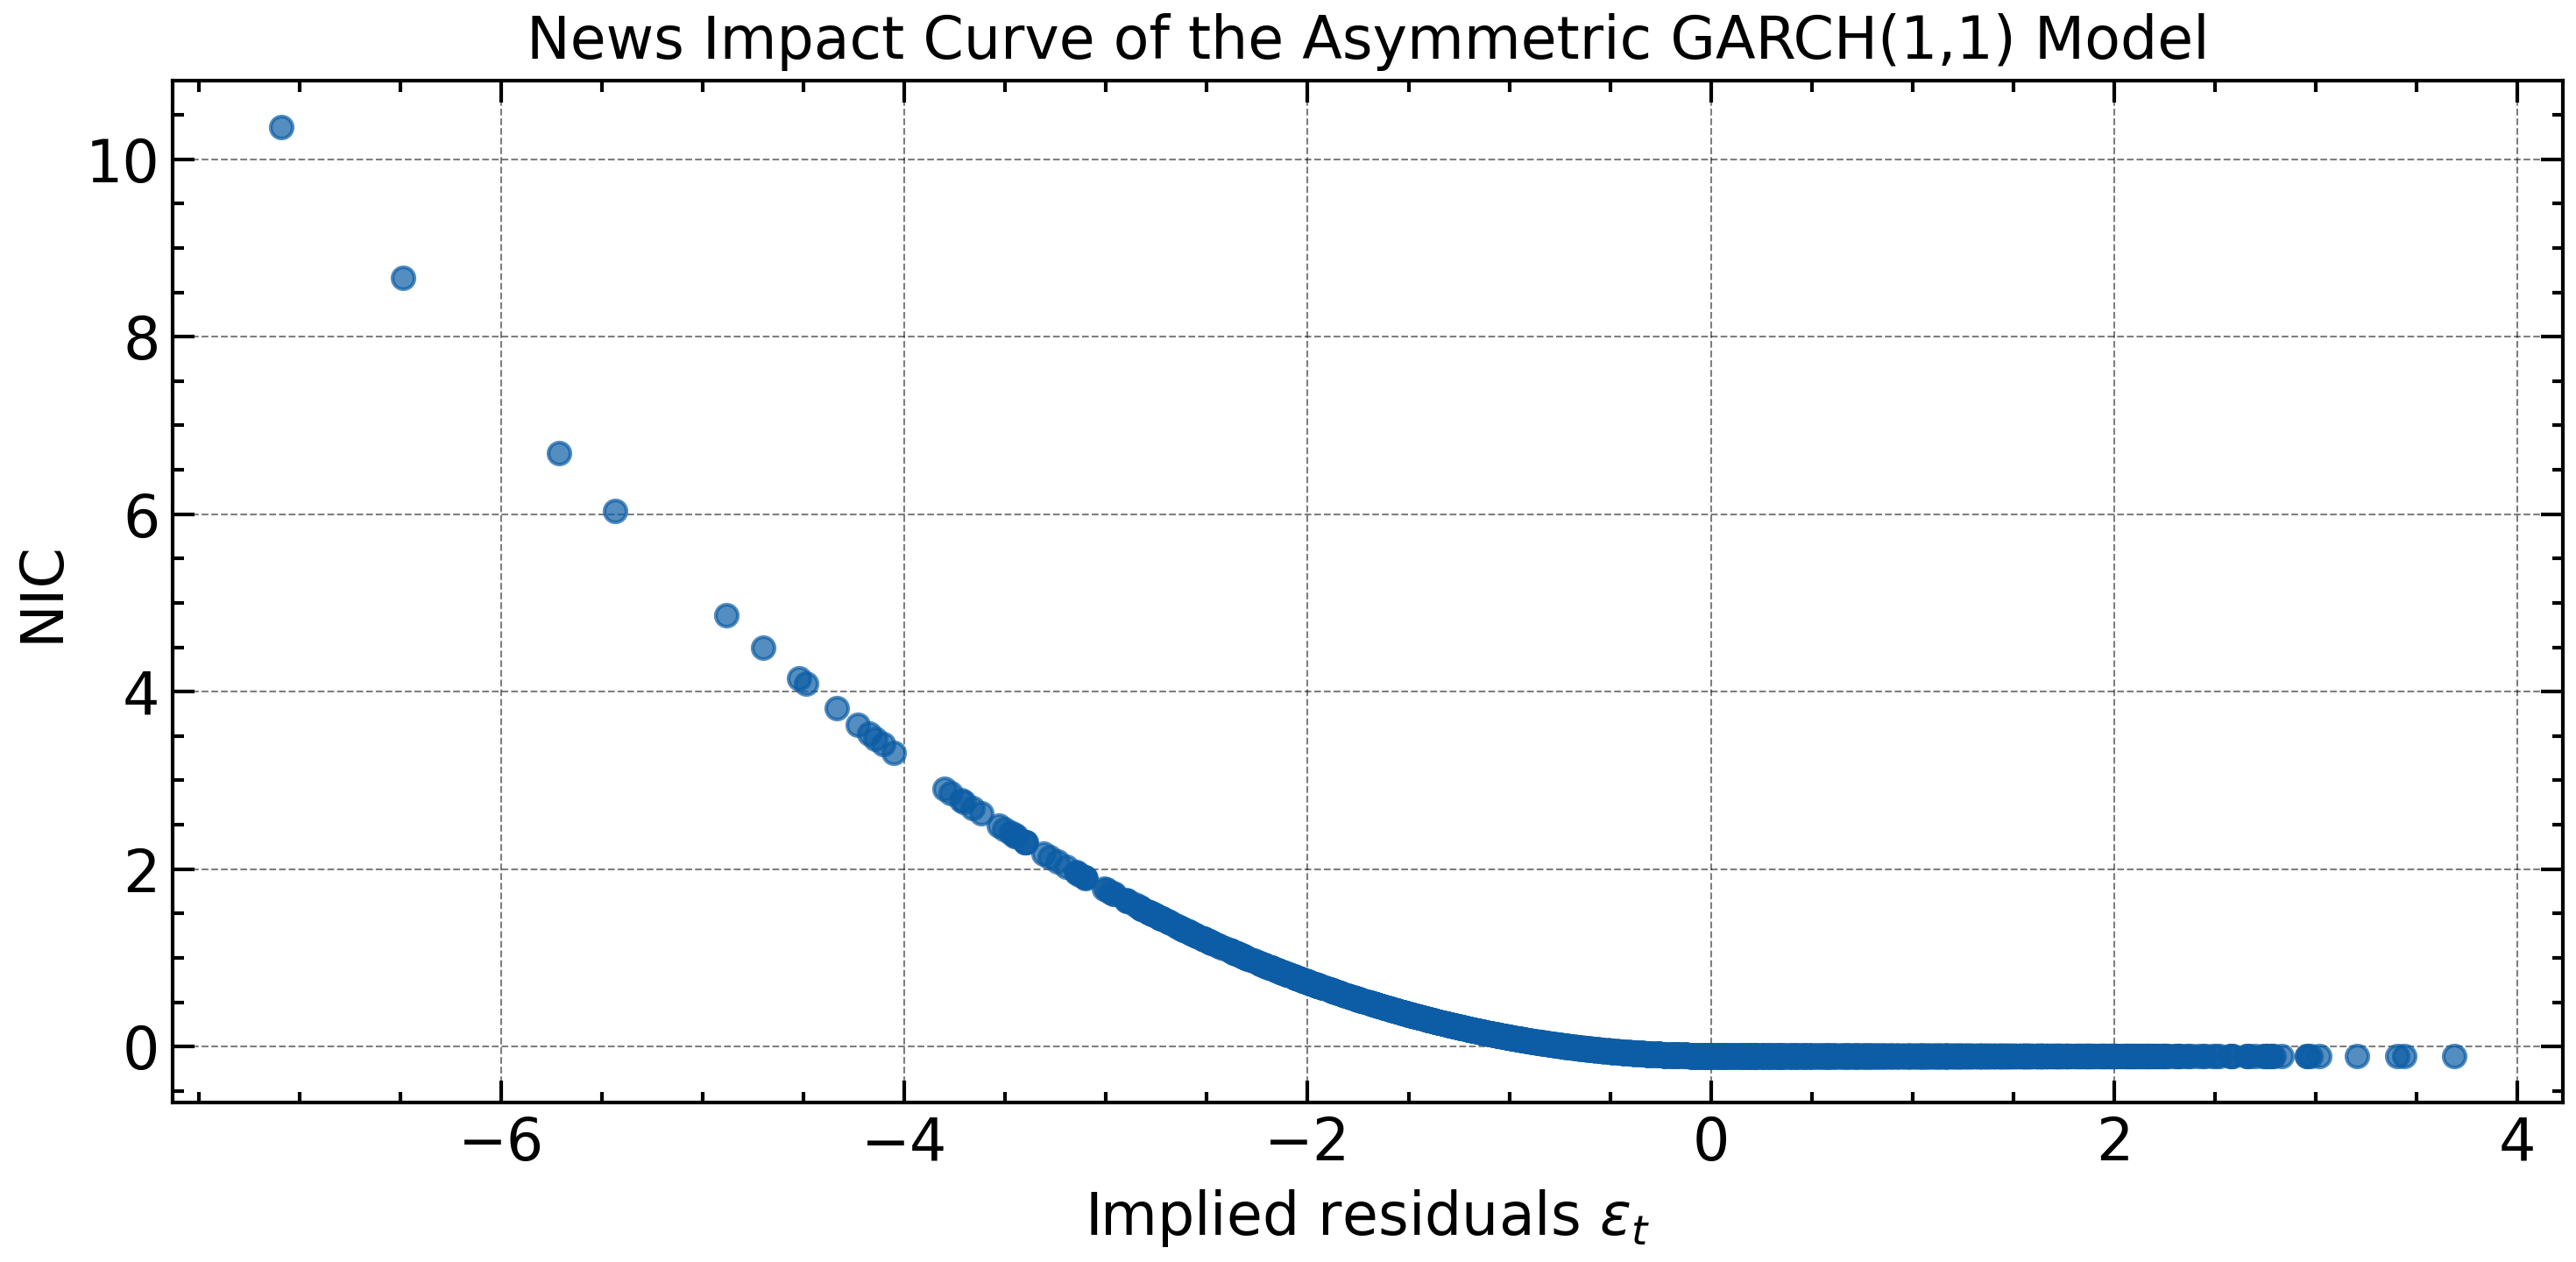

In [5]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize_model('Asymmetric GARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, nu_hat = result.x
log_likelihood = -result.fun
sigma_squared = asymmetric_garch(result.x, returns)

plot_results(dates, returns, sigma_squared, 'Asymmetric GARCH(1,1)')

# Print results
print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu          : {mu_hat:.3f}")
print(f"  omega       : {omega_hat:.3f}")
print(f"  alpha_pos   : {alpha_hat_pos:.3f}")
print(f"  alpha_neg   : {alpha_hat_neg:.3f}")
print(f"  beta        : {beta_hat:.3f}")
print(f"  nu          : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = alpha_hat_pos * (epsilon**2 * (epsilon >= 0) - 1/2) + alpha_hat_neg * (epsilon**2 * (epsilon < 0) - 1/2)
plot_nic(epsilon, nic, 'Asymmetric GARCH(1,1) Model')

# Comparing Symmetric vs Asymmetric GARCH(1,1) models

In [6]:
# Estimate Parameters for Symmetric GARCH
initial_values_symmetric = [np.mean(returns), np.var(returns) / 20, 0.10, 0.88, 6]
bounds_symmetric = [(None, None), (0, None), (0, None), (0, None), (2, 40)]
result_symmetric = optimize_model('GARCH', initial_values_symmetric, bounds_symmetric, returns)
log_likelihood_symmetric = -result_symmetric.fun

# Estimate Parameters for Asymmetric GARCH
initial_values_asymmetric = [np.mean(returns), np.var(returns) / 20, 0.10, 0.10, 0.88, 6]
bounds_asymmetric = [(None, None), (0, None), (0, None), (0, None), (0, None), (2, 40)]
result_asymmetric = optimize_model('Asymmetric GARCH', initial_values_asymmetric, bounds_asymmetric, returns)
log_likelihood_asymmetric = -result_asymmetric.fun

# Compute Likelihood Ratio Statistic
LR_statistic = -2 * (log_likelihood_symmetric - log_likelihood_asymmetric)

# Degrees of freedom (difference in the number of parameters)
df = len(result_asymmetric.x) - len(result_symmetric.x)

# Compare with Chi-square Distribution
p_value = stats.chi2.sf(LR_statistic, df)

print("Likelihood Ratio Statistic:", LR_statistic)
print("Degrees of Freedom:", df)
print("P-value:", p_value)

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: divide by zero encountered in divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: invalid value encountered in multiply
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:69: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c

Likelihood Ratio Statistic: 199.71000589390678
Degrees of Freedom: 1
P-value: 2.416102341700114e-45


# Symmetric Beta-t-GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:50: RuntimeWarning: overflow encountered in exp
  sigma[t] = np.exp(lambdas[t])
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:49: RuntimeWarning: overflow encountered in scalar multiply
  lambdas[t] = lam * (1 - phi) + phi * lambdas[t-1] + kappa * u[t-1] + kappa_tilde * v[t-1]
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:54: RuntimeWarning: overflow encountered in square
  return sigma**2, u, v
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:52: RuntimeWarning: overflow encountered in scalar power
  u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:52: RuntimeWarning: invalid value encountered in scalar multiply
  u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2

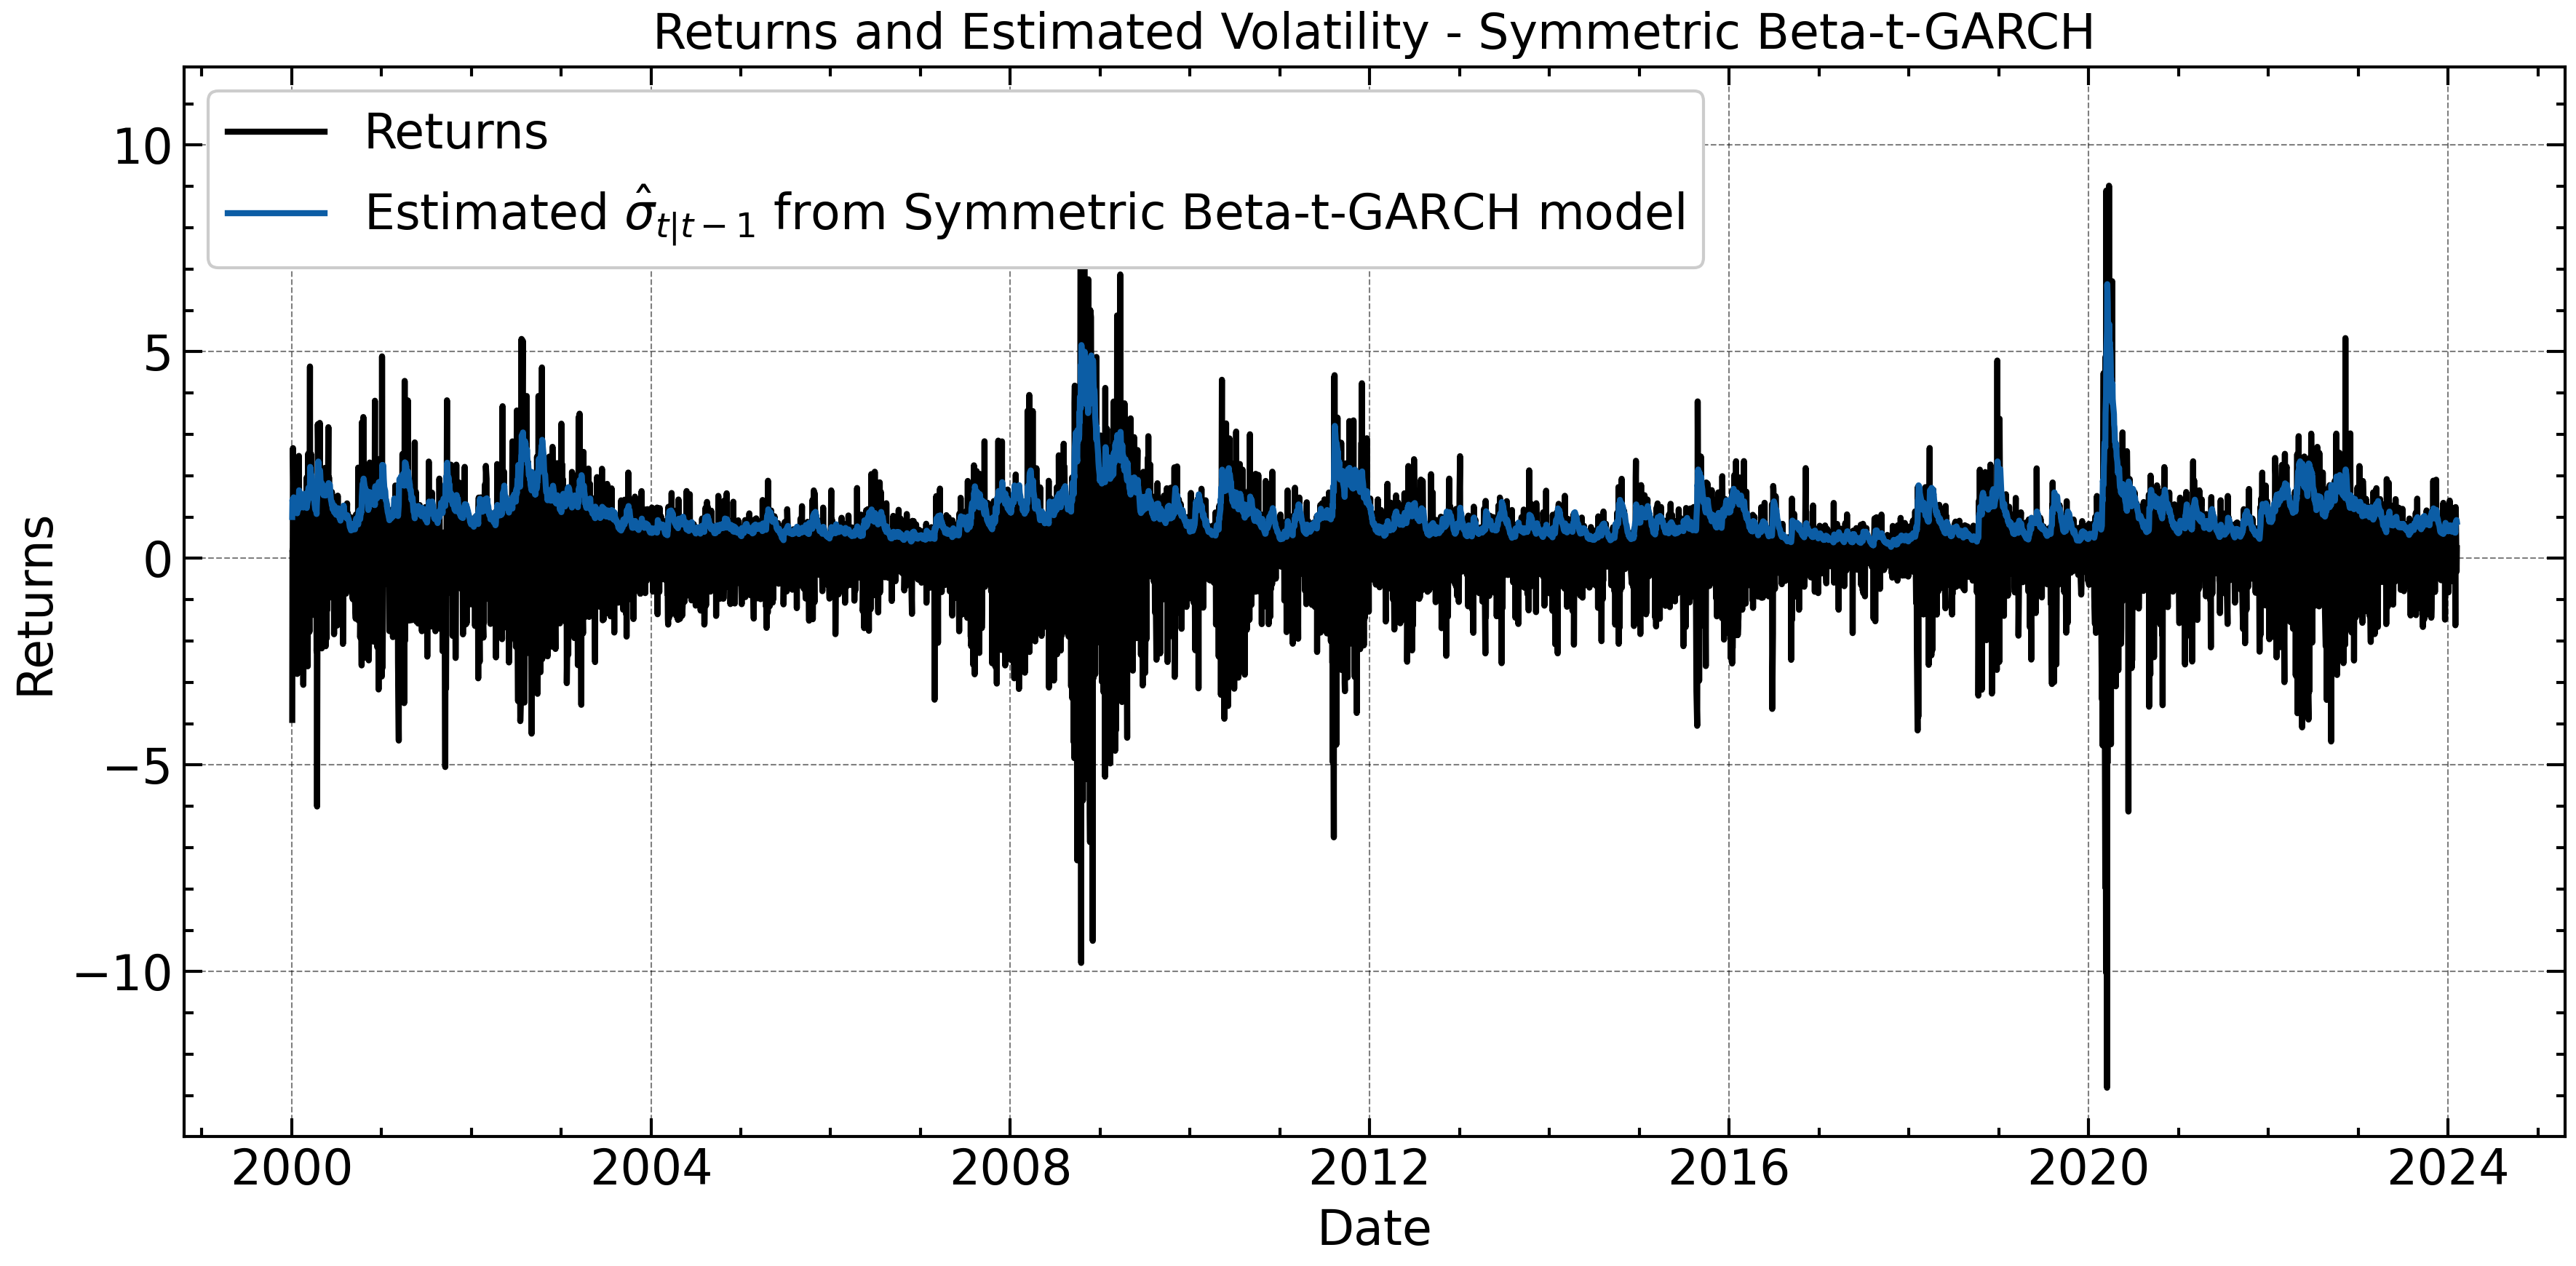

Optimization Successful: Yes
Estimated Parameters:
  mu     : 0.076
  lam    : 0.000
  phi    : 0.983
  kappa  : 0.080
  k_tilde: 0.000
  nu     : 7.178
Log-Likelihood: -8228.8


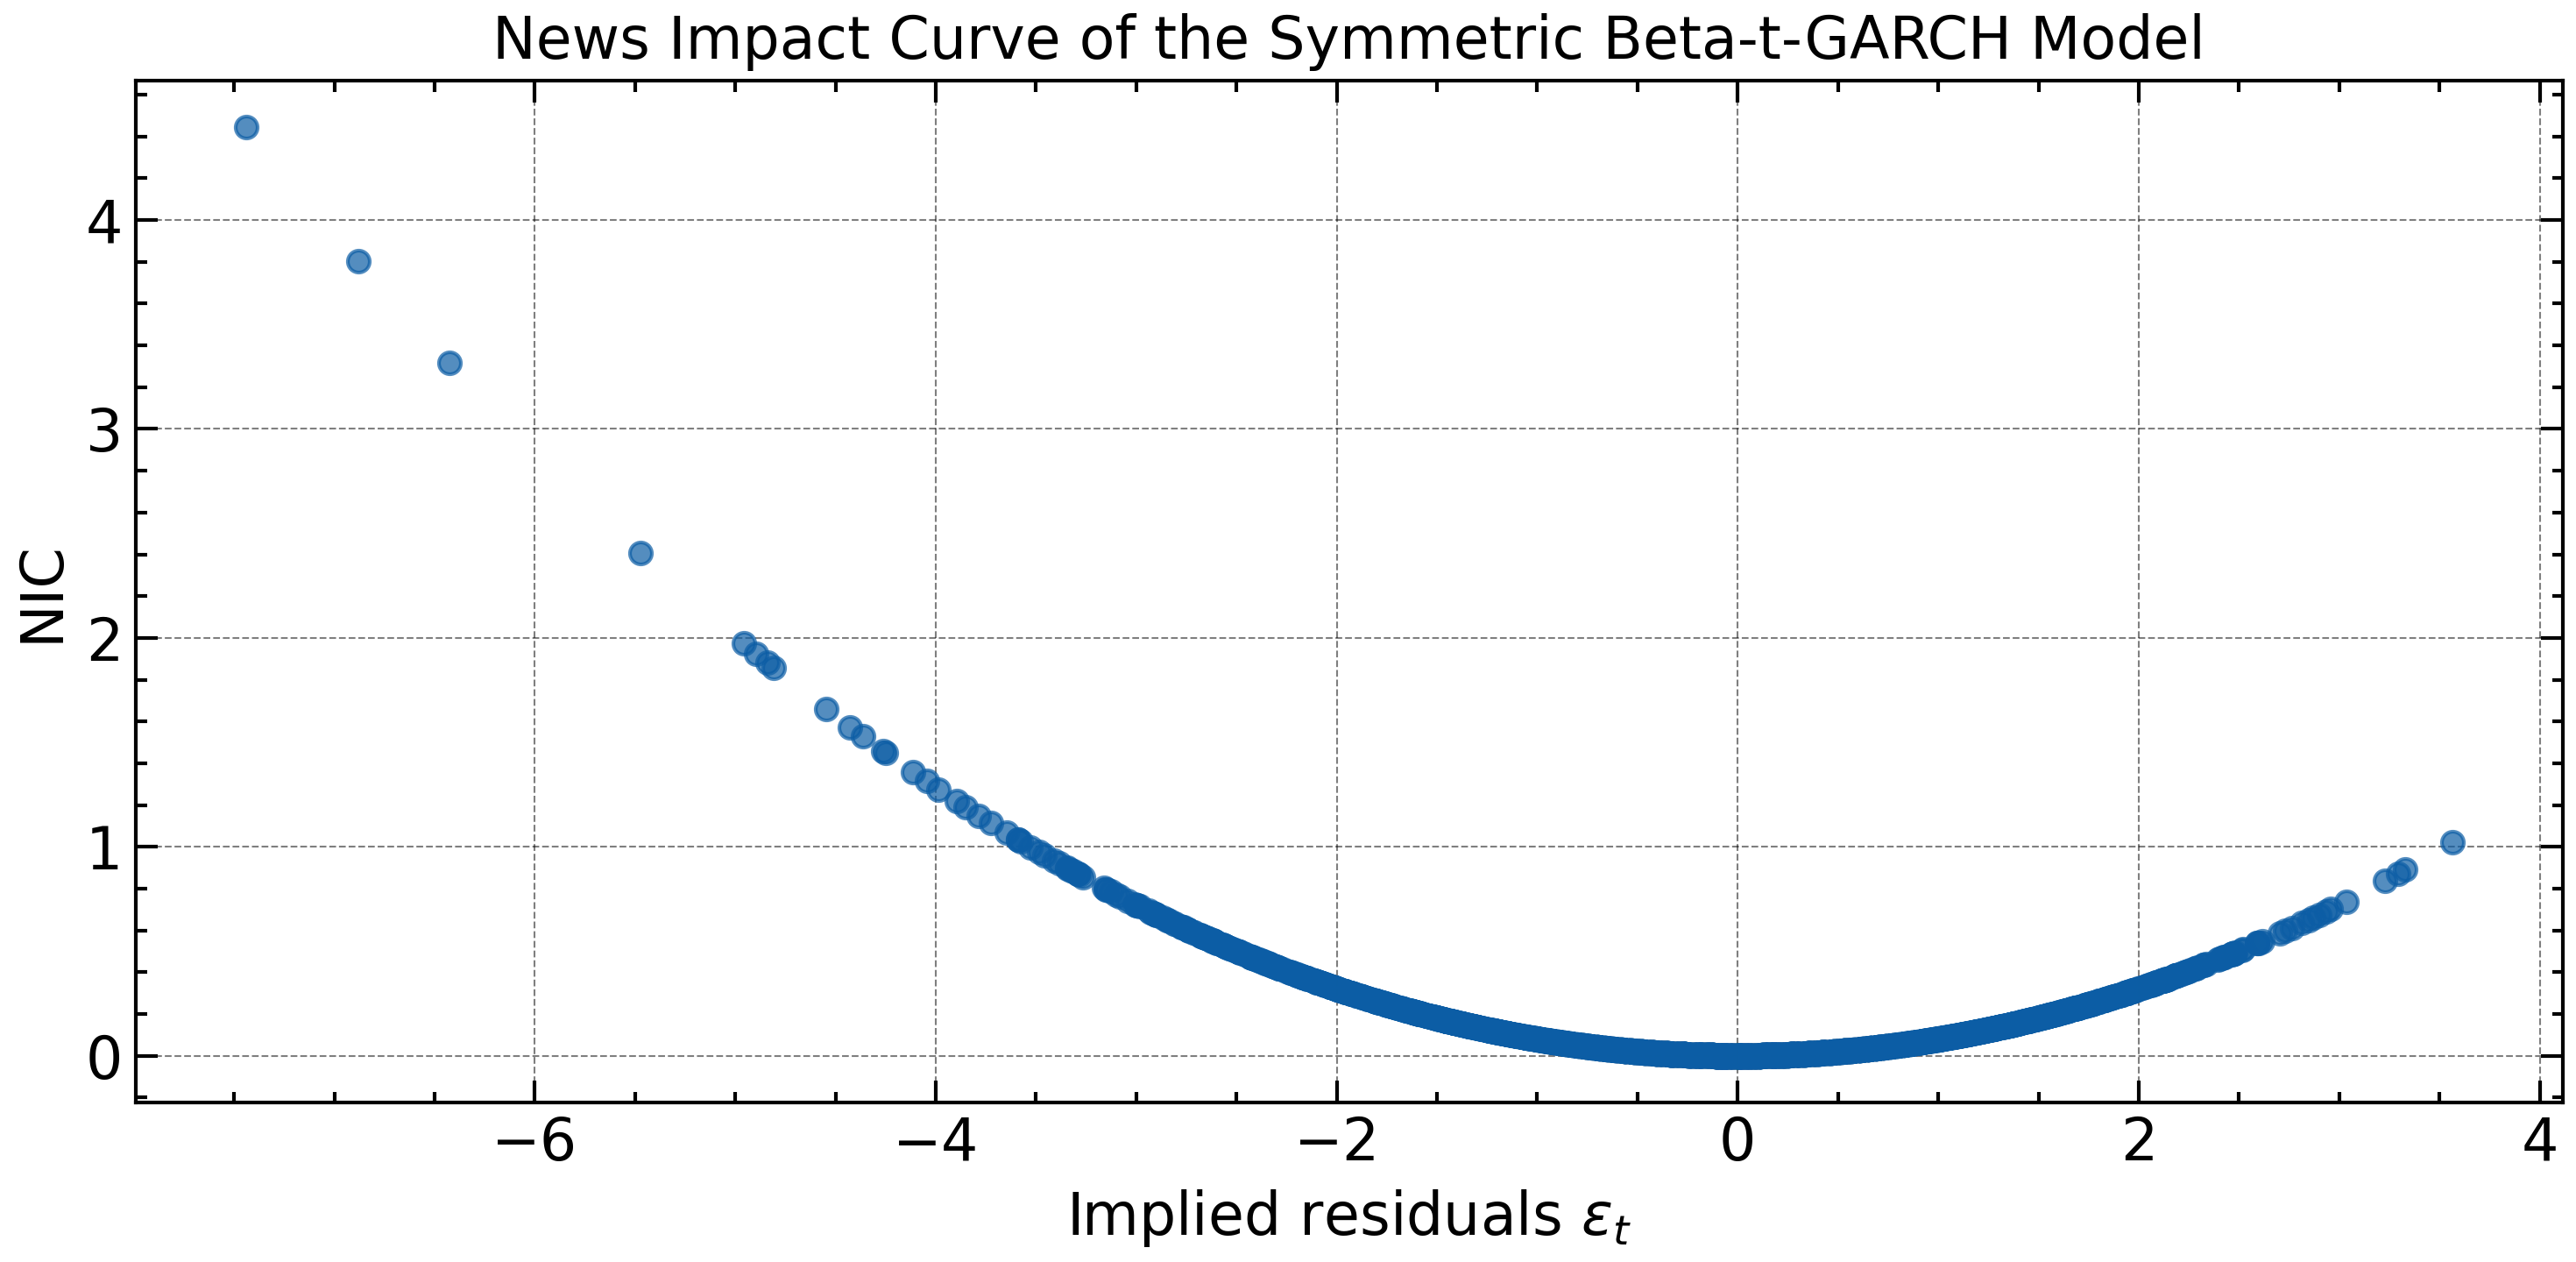

In [7]:
# Define optimization problem
initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
bounds = [(None, None), (None, None), (None, None), (None, None), (0, 0), (2, 40)] # Constrain kappa_tilde = 0
result = optimize_model('Symmetric Beta-t-GARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, lam_hat, phi_hat, kappa_hat, k_tilde_hat, nu_hat = result.x
log_likelihood = -result.fun
sigma_squared = asymmetric_beta_t_egarch(result.x, returns)[0]

plot_results(dates, returns, sigma_squared, 'Symmetric Beta-t-GARCH')

print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu     : {mu_hat:.3f}")
print(f"  lam    : {lam_hat:.3f}")
print(f"  phi    : {phi_hat:.3f}")
print(f"  kappa  : {kappa_hat:.3f}")
print(f"  k_tilde: {k_tilde_hat:.3f}")
print(f"  nu     : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

conditional_var = asymmetric_beta_t_egarch(result.x, returns)[0]
epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = kappa_hat * (epsilon**2) + k_tilde_hat * epsilon
plot_nic(epsilon, nic, 'Symmetric Beta-t-GARCH Model')

# Asymmetric Beta-t-EGARCH,

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:50: RuntimeWarning: overflow encountered in exp
  sigma[t] = np.exp(lambdas[t])
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:52: RuntimeWarning: invalid value encountered in scalar multiply
  u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  v[t] = np.sqrt((nu + 2) * (nu + 3) / (nu + (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:53: RuntimeWarning: inv

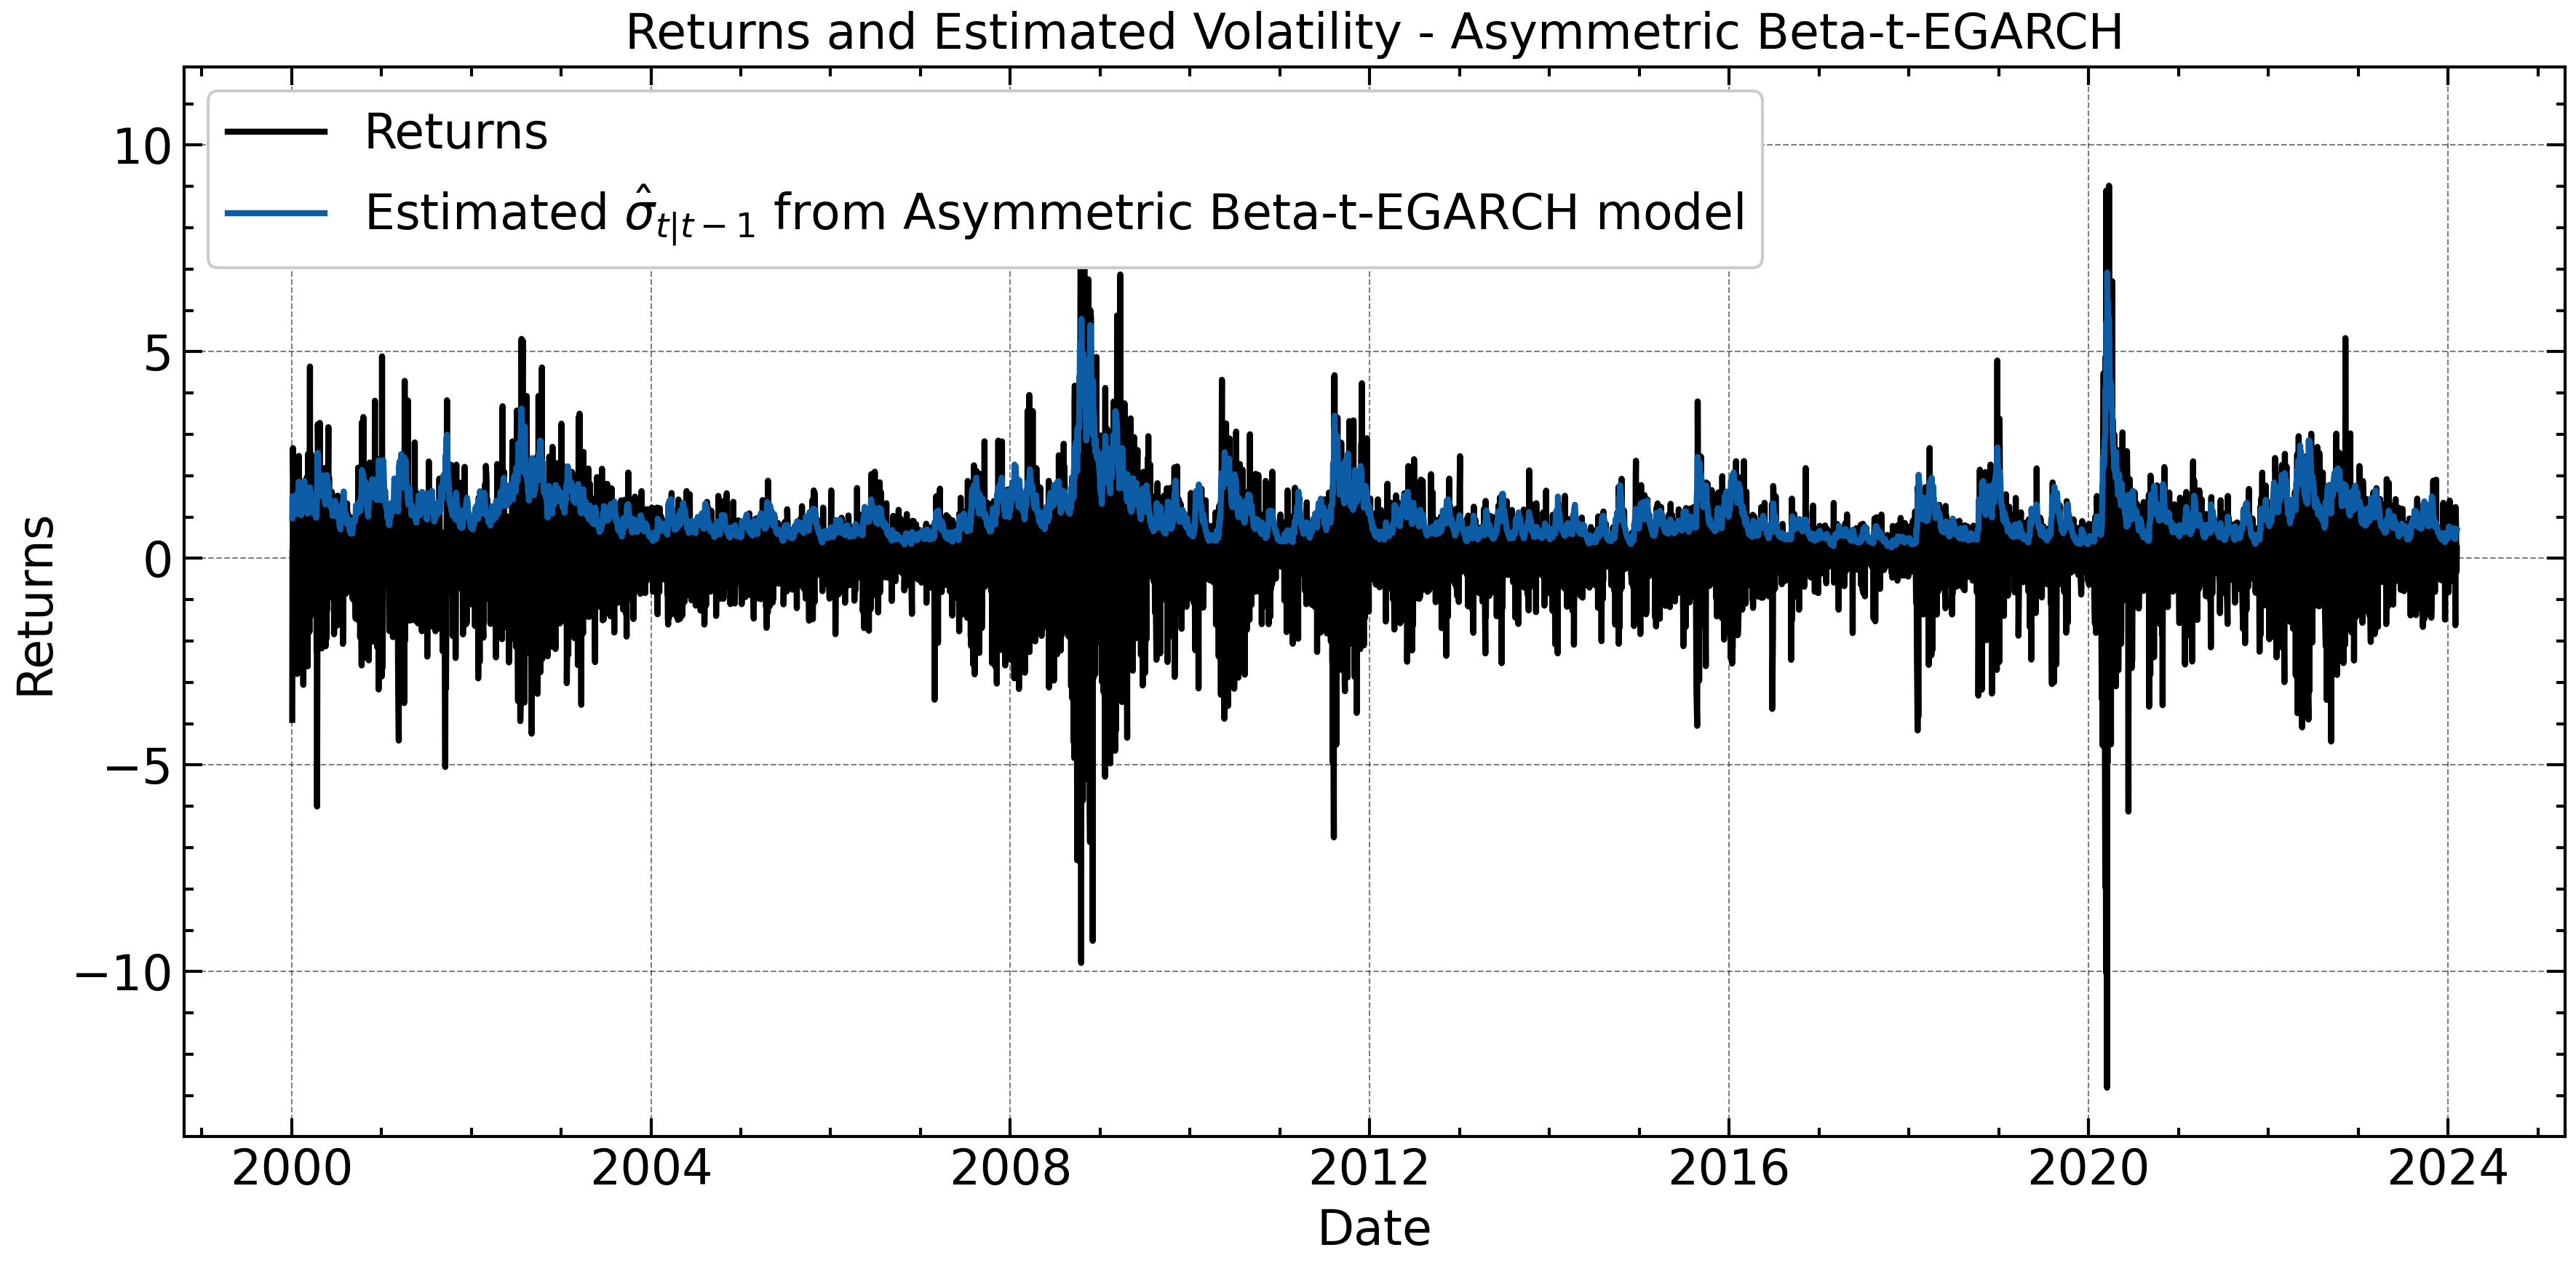

Optimization Successful: Yes
Estimated Parameters:
  mu     : 0.036
  lam    : -0.029
  phi    : 0.974
  kappa  : 0.061
  k_tilde: -0.034
  nu     : 8.497
Log-Likelihood: -8088.5


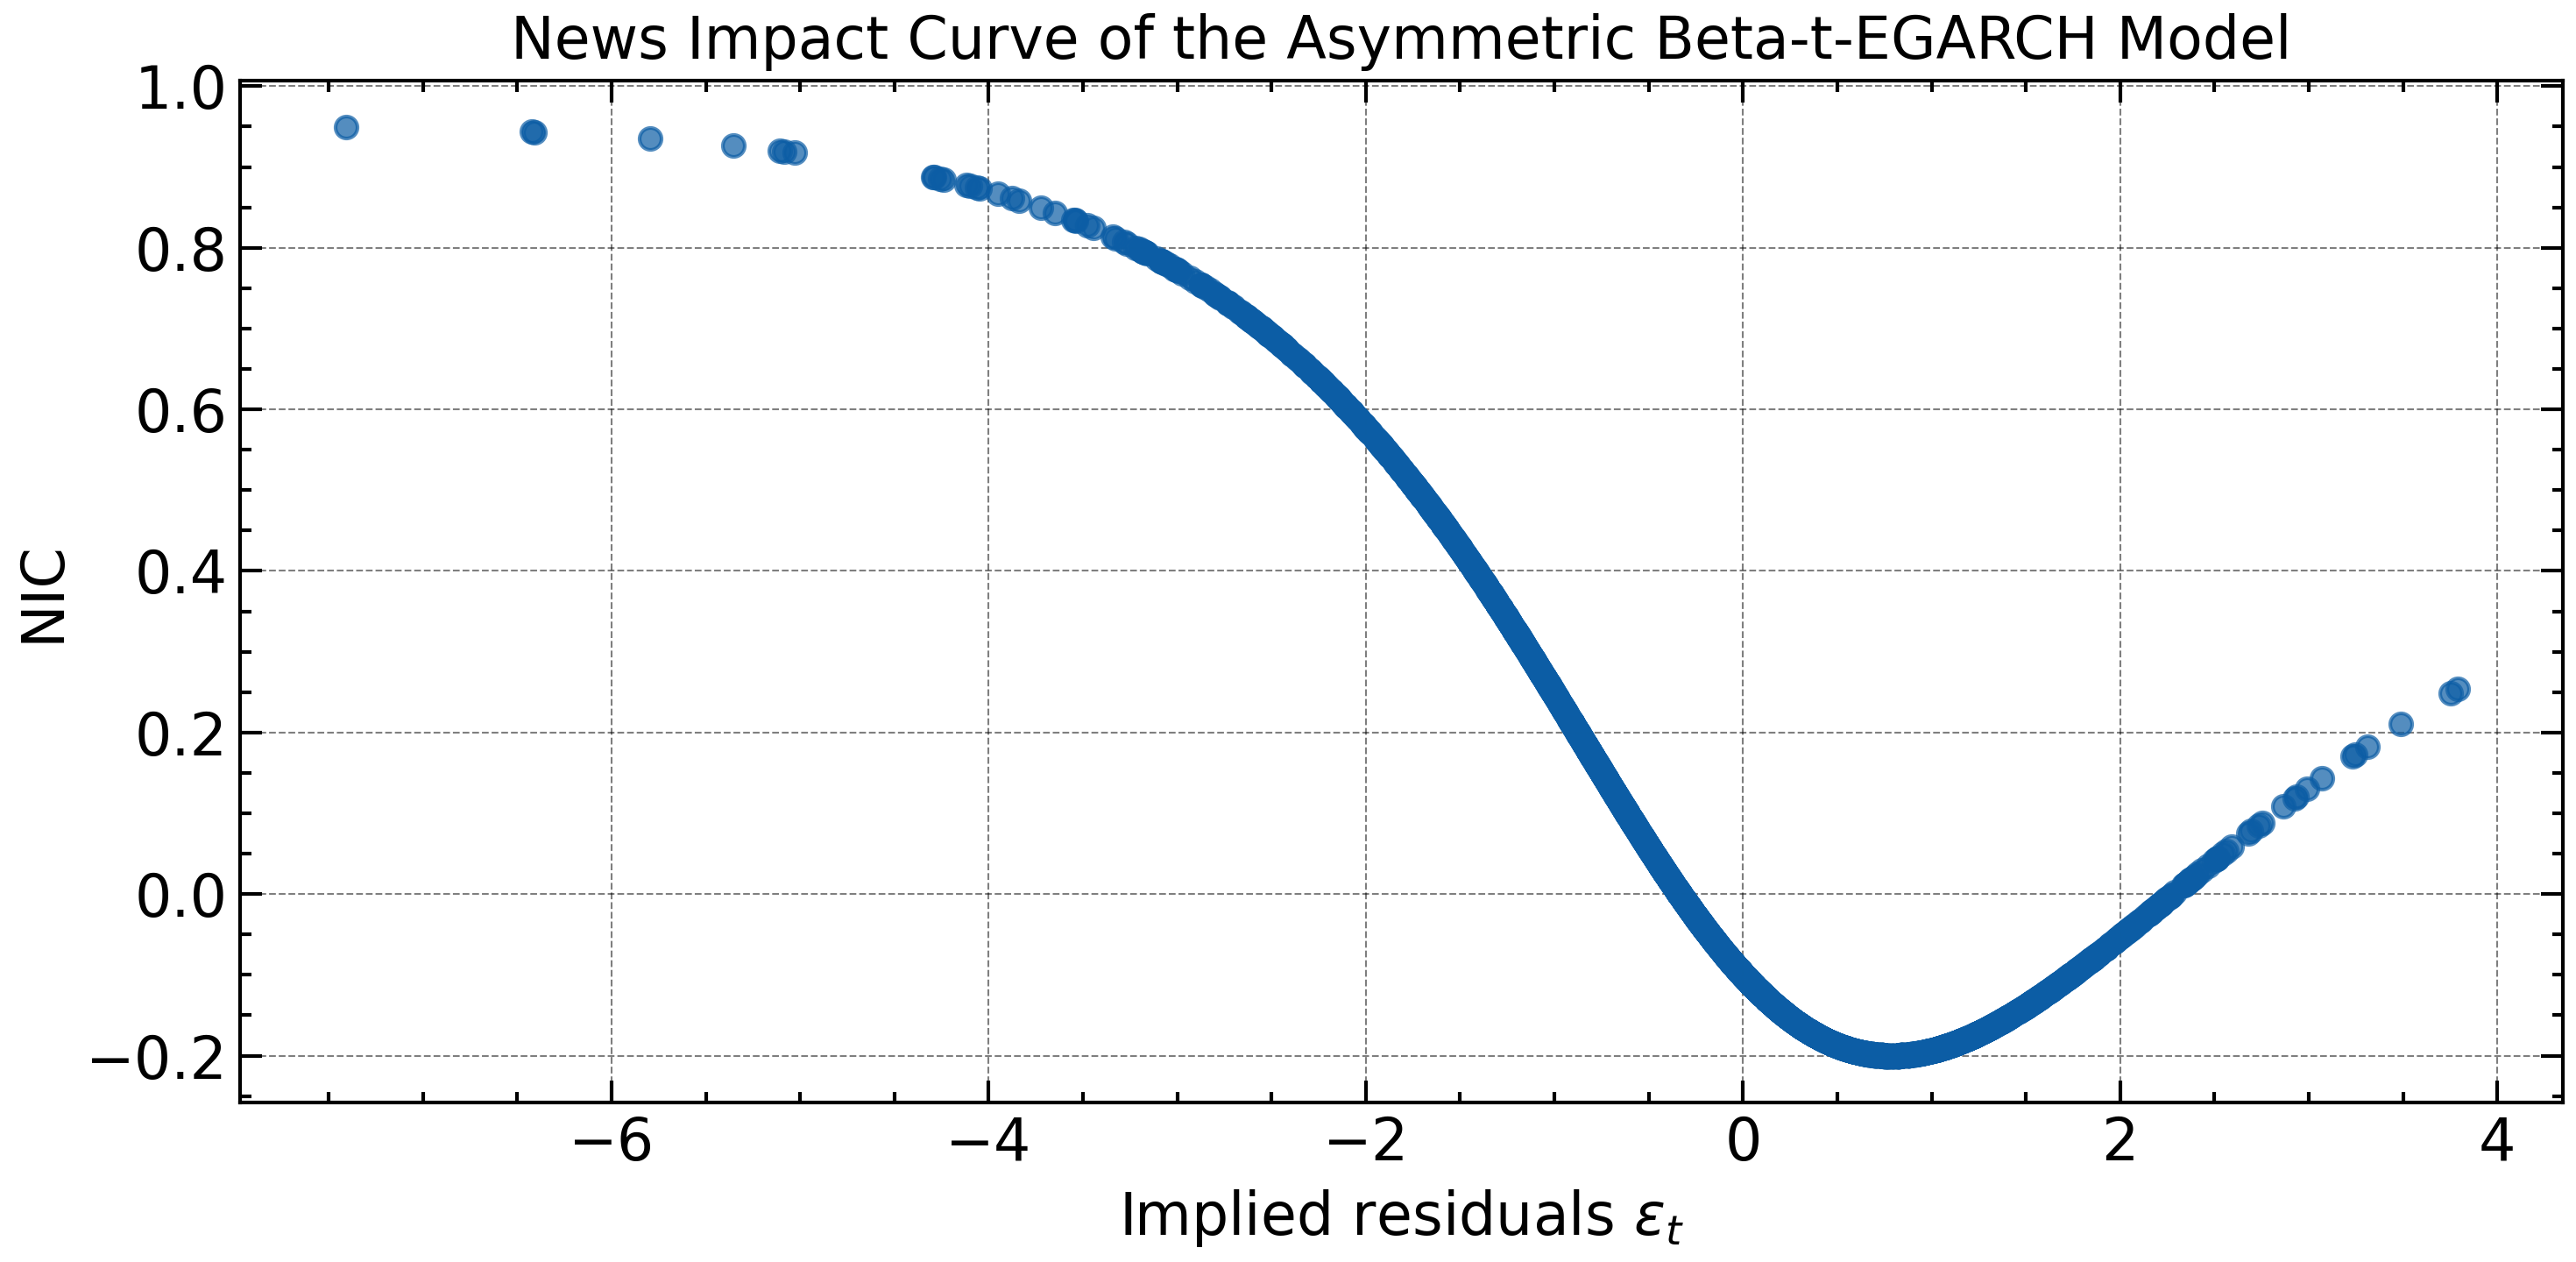

In [8]:
# Define optimization problem
initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
bounds = [(None, None), (None, None), (None, None), (None, None), (None, None), (2, None)]
result = optimize_model('Asymmetric Beta-t-EGARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, lam_hat, phi_hat, kappa_hat, k_tilde_hat, nu_hat = result.x
log_likelihood = -result.fun
conditional_var, u, v = asymmetric_beta_t_egarch(result.x, returns)

plot_results(dates, returns, conditional_var, 'Asymmetric Beta-t-EGARCH')

print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu     : {mu_hat:.3f}")
print(f"  lam    : {lam_hat:.3f}")
print(f"  phi    : {phi_hat:.3f}")
print(f"  kappa  : {kappa_hat:.3f}")
print(f"  k_tilde: {k_tilde_hat:.3f}")
print(f"  nu     : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

nic = 2 * kappa_hat * u + 2 * k_tilde_hat * v
plot_nic((returns - mu_hat) / np.sqrt(conditional_var), nic, 'Asymmetric Beta-t-EGARCH Model')

# Comparing Symmetric vs Asymmetric Beta-t-EGARCH models

In [9]:
# Estimate Parameters for Symmetric Beta-t-GARCH
initial_values_symmetric_beta_t = [np.mean(returns), 0, 0.95, 0.1, 0, 6]
bounds_symmetric_beta_t = [(None, None), (None, None), (None, None), (None, None), (0, 0), (2, 40)]
result_symmetric_beta_t = optimize_model('Symmetric Beta-t-GARCH', initial_values_symmetric_beta_t, bounds_symmetric_beta_t, returns)
log_likelihood_symmetric_beta_t = -result_symmetric_beta_t.fun

# Estimate Parameters for Asymmetric Beta-t-GARCH
initial_values_asymmetric_beta_t = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
bounds_asymmetric_beta_t = [(None, None), (None, None), (None, None), (None, None), (None, None), (2, None)]
result_asymmetric_beta_t = optimize_model('Asymmetric Beta-t-EGARCH', initial_values_asymmetric_beta_t, bounds_asymmetric_beta_t, returns)
log_likelihood_asymmetric_beta_t = -result_asymmetric_beta_t.fun

# Compute Likelihood Ratio Statistic
LR_statistic_beta_t = -2 * (log_likelihood_symmetric_beta_t - log_likelihood_asymmetric_beta_t)
df_beta_t = 1
p_value_beta_t = stats.chi2.sf(LR_statistic_beta_t, df_beta_t)

print("Likelihood Ratio Statistic:", LR_statistic_beta_t)
print("Degrees of Freedom:", df_beta_t)
print("P-value:", p_value_beta_t)

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:50: RuntimeWarning: overflow encountered in exp
  sigma[t] = np.exp(lambdas[t])
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:49: RuntimeWarning: overflow encountered in scalar multiply
  lambdas[t] = lam * (1 - phi) + phi * lambdas[t-1] + kappa * u[t-1] + kappa_tilde * v[t-1]
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:54: RuntimeWarning: overflow encountered in square
  return sigma**2, u, v
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:52: RuntimeWarning: overflow encountered in scalar power
  u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:52: RuntimeWarning: invalid value encountered in scalar multiply
  u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2

Likelihood Ratio Statistic: 280.48717484513327
Degrees of Freedom: 1
P-value: 5.880748732544633e-63


# Compare News Impact Curves

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: divide by zero encountered in divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: invalid value encountered in multiply
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:69: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c

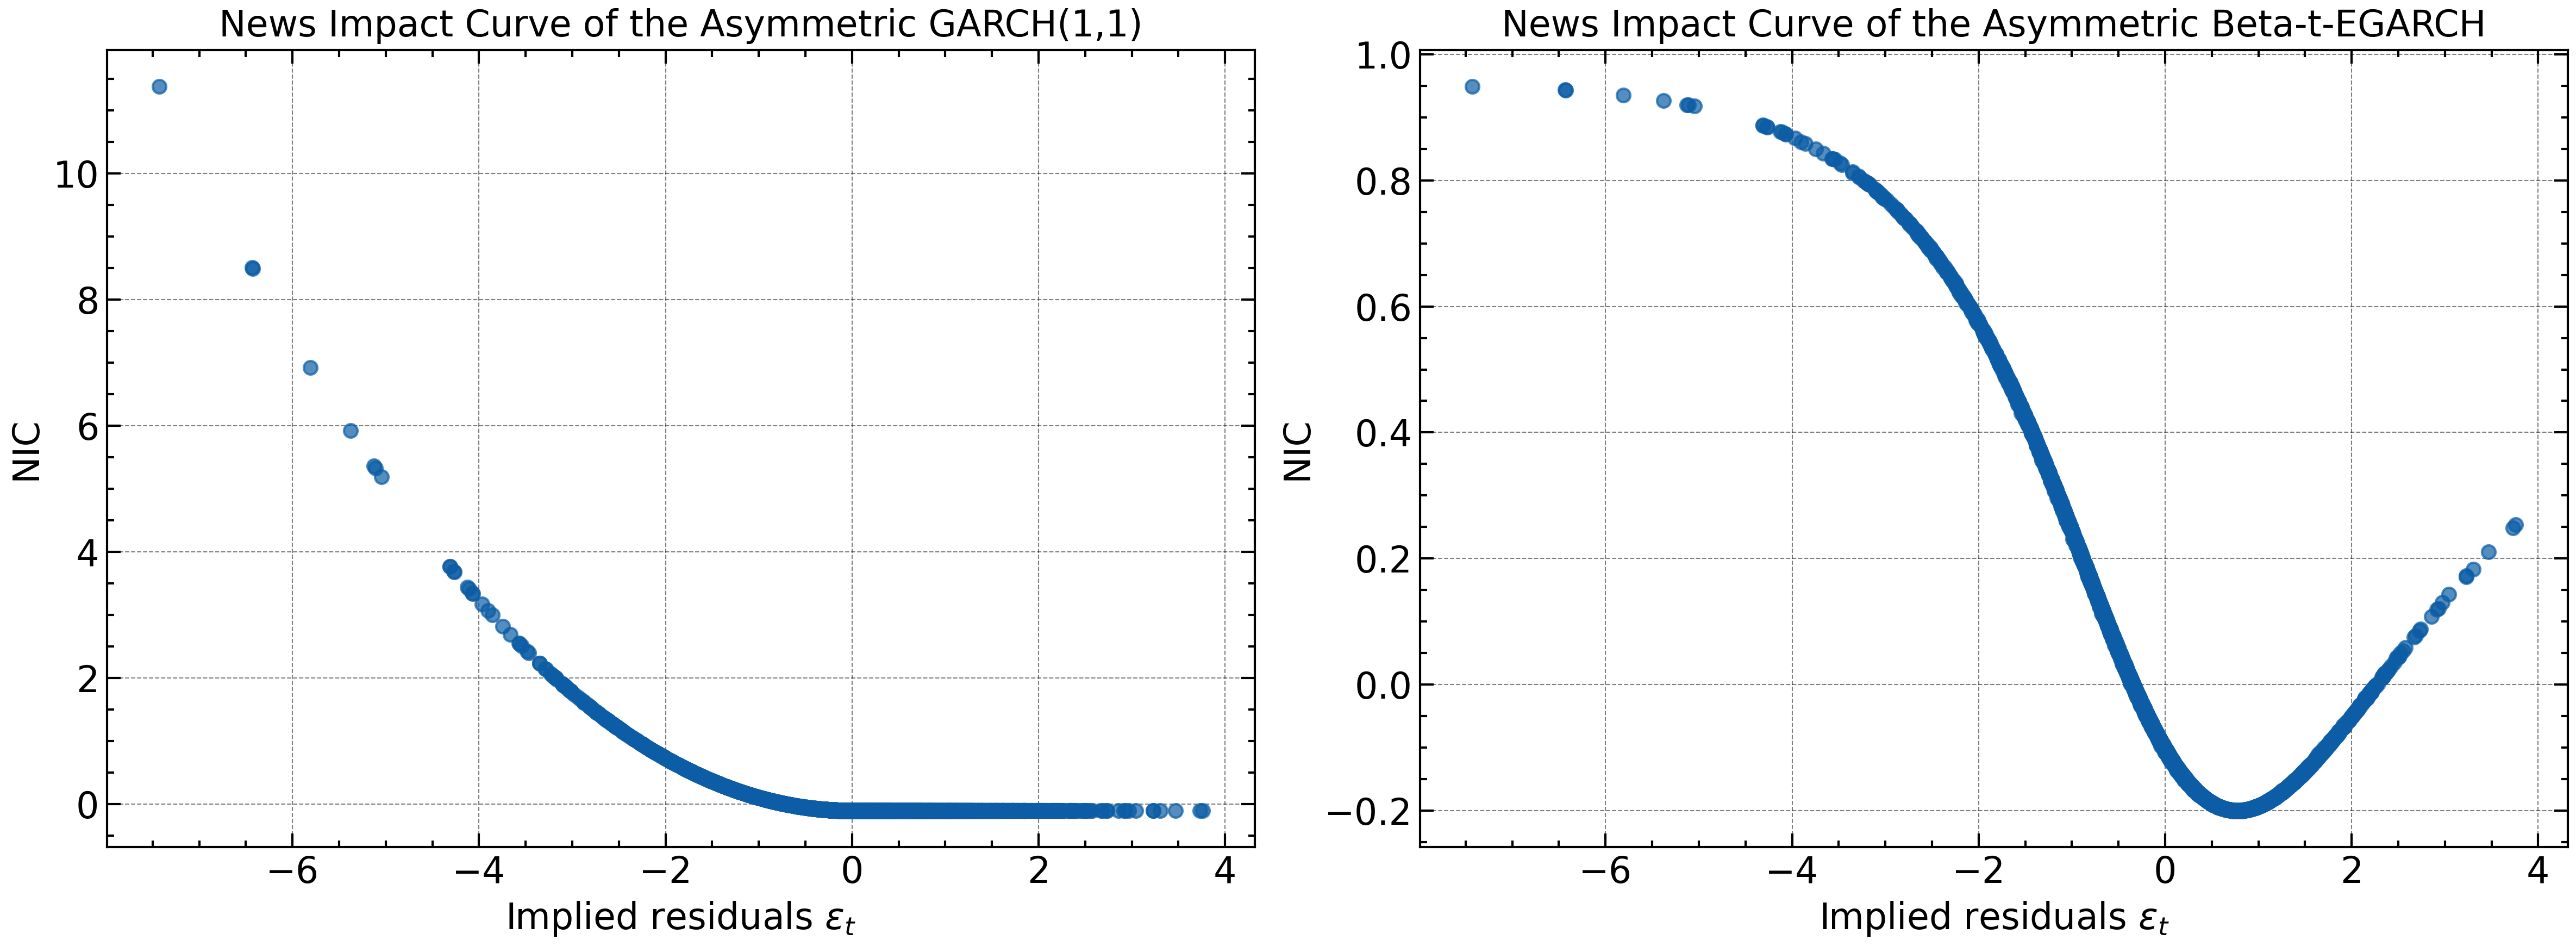

In [17]:
def plot_nic_subplot(epsilon, nic, model_name, ax):
    ax.scatter(epsilon, nic, alpha=0.7)
    ax.set_xlabel('Implied residuals $\epsilon_t$')
    ax.set_ylabel('NIC')
    ax.set_title(f'News Impact Curve of the {model_name}')
    ax.grid(True)

# Define optimization problem
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize_model('Asymmetric GARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, nu_hat = result.x
log_likelihood = -result.fun
sigma_squared = asymmetric_garch(result.x, returns)

epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic_asymmetric_garch_values = alpha_hat_pos * (epsilon**2 * (epsilon >= 0) - 1/2) + alpha_hat_neg * (epsilon**2 * (epsilon < 0) - 1/2)

# Define optimization problem
initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
bounds = [(None, None), (None, None), (None, None), (None, None), (None, None), (2, None)]
result = optimize_model('Asymmetric Beta-t-EGARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, lam_hat, phi_hat, kappa_hat, k_tilde_hat, nu_hat = result.x
log_likelihood = -result.fun
conditional_var, u, v = asymmetric_beta_t_egarch(result.x, returns)

nic_asymmetric_beta_t_values = 2 * kappa_hat * u + 2 * k_tilde_hat * v

# Plot NIC for both models
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

plot_nic_subplot(epsilon, nic_asymmetric_garch_values, 'Asymmetric GARCH(1,1)', axes[0])
plot_nic_subplot(epsilon, nic_asymmetric_beta_t_values, 'Asymmetric Beta-t-EGARCH', axes[1])

plt.tight_layout()
plt.show()

# Mincer-Zarnowitz regressions

In [11]:
# Mincer-Zarnowitz regressions
def optimize_and_forecast(model_type, initial_values, bounds, returns, horizons):
    # Model optimization
    result = optimize_model(model_type, initial_values, bounds, returns)
    if not result.success:
        raise ValueError(f"Optimization failed for {model_type}")

    # Extract optimized parameters
    parameters = result.x

    # Forecasting and analysis
    results = {}
    for d in horizons:
        if model_type == 'Asymmetric GARCH':
            forecast_var = PVolGARCH(d, parameters, returns)
        elif model_type == 'Asymmetric Beta-t-EGARCH':
            forecast_var = PVolBeta_t_GARCH(d, parameters, returns)
        else:
            raise ValueError("Invalid model type")

        # Calculate forecasts and actuals
        actual_var = target_variable1(returns, d)

        # Ensure same length
        min_len = min(len(actual_var), len(forecast_var))
        actual_var = actual_var[:min_len]
        forecast_var = forecast_var[:min_len]

        # Mincer-Zarnowitz regression
        mv_model = mincer_zarnowitz(actual_var, forecast_var)
        results[d] = {
            'parameters': mv_model.params,
            'pvalues': mv_model.pvalues,
            'stderr': mv_model.bse,
            'rmse': np.sqrt(mv_model.mse_resid),
            'r_squared': mv_model.rsquared
        }
    return results

# Example usage:
horizons = [1, 5, 21]
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.10, 0.88, 6]
bounds = [(None, None), (None, None), (None, None), (None, None), (None, None), (2, None)]

# Asymmetric GARCH model
asym_garch_results = optimize_and_forecast('Asymmetric GARCH', initial_values, bounds, returns, horizons)
# Asymmetric Beta-t-EGARCH model
asym_beta_egarch_results = optimize_and_forecast('Asymmetric Beta-t-EGARCH', initial_values, bounds, returns, horizons)

def format_results(model_name, results):
    formatted_data = []
    for d, res in results.items():
        formatted_data.append({
            'Horizon (days)': d,
            'Coefficients': res['parameters'],
            'StdErr': res['stderr'],
            'RMSE': res['rmse'],
            'R^2': res['r_squared']
        })
    df = pd.DataFrame(formatted_data)
    df.set_index('Horizon (days)',inplace=True)
    return df

# Example usage
print("\n Asymmetric GARCH Model Results:")
display(format_results("Asymmetric GARCH", asym_garch_results))
print("\n Asymmetric Beta-t-EGARCH Model Results:")
display(format_results("Asymmetric Beta-t-EGARCH", asym_beta_egarch_results))


/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:27: RuntimeWarning: overflow encountered in scalar multiply
  sigma_squared[t] = omega + shock_effect + beta * sigma_squared[t-1]
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:69: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:70: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_47398/2519999361.py:5: RuntimeWarning: divide by zero encou


 Asymmetric GARCH Model Results:


,Coefficients,StdErr,RMSE,R^2
Horizon (days),,,,
1,"[0.12017862492177599, 0.8517091640656669]","[0.063855386175538, 0.017685057725576957]",4.445183,0.276828
5,"[1.0401679266928754, 0.8017185636211711]","[0.18677737880519577, 0.01057193168958509]",12.943338,0.487120
21,"[10.48732469830602, 0.6329294348661029]","[0.727411356049178, 0.010650544762297409]",49.434166,0.369003



 Asymmetric Beta-t-EGARCH Model Results:


,Coefficients,StdErr,RMSE,R^2
Horizon (days),,,,
1,"[-0.236426804622777, 1.16342228054966]","[0.06514710596175353, 0.022458819316793176]",4.351627,0.306948
5,"[-1.2259556967926823, 1.2079826309066135]","[0.1890465788494761, 0.014402785102050734]",12.292365,0.537413
21,"[-4.201269776954468, 1.28295793584621]","[0.8254758024131635, 0.0198056832216515]",47.802437,0.409971


# Out-of-Sample testing

In [ ]:
start_up = 252
T = len(returns)

# start_up = max(start_up, lookback)

initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
bounds = [(None, None), (None, None), (None, None), (None, None), (None, None), (2, None)]


for t in range(start_up, T):
    result = optimize_model('Asymmetric Beta-t-EGARCH', initial_values, bounds, returns[:t])
    
    asymmetric_beta_t_egarch(result.x, returns)

In [15]:
returns

array([-3.9100597 ,  0.19703736,  0.09481072, ...,  1.05617472,
       -0.31979018,  0.2431176 ])

In [16]:
returns[:3]

array([-3.9100597 ,  0.19703736,  0.09481072])

In [ ]:
def garch_conformal_forecasting(returns, alpha, gamma, lookback=1250, garch_p=1, garch_q=1, start_up=100, verbose=False, update_method="Simple", momentum_bw=0.95):
    T = len(returns)
    start_up = max(start_up, lookback)
    
    # Rescale returns if necessary
    scale_factor = 100
    returns_scaled = returns * scale_factor

    # Initialize data storage variables
    err_seq_oc = np.zeros(T - start_up + 1)
    err_seq_nc = np.zeros(T - start_up + 1)
    alpha_sequence = np.full(T - start_up + 1, alpha)
    scores = np.zeros(T - start_up + 1)

    alphat = alpha

    for t in range(start_up, T):
        # Fit GARCH model and compute new conformity score
        garch_model = arch_model(returns[(t-lookback):(t)], mean='Zero', vol='Garch', p=garch_p, q=garch_q, rescale=True)
        garch_fit = garch_model.fit(disp='off')
        sigma_next = garch_fit.forecast(horizon=1).variance.iloc[-1, -1] ** 0.5

        # Corrected line to avoid FutureWarning
        return_t = returns.iloc[t] if isinstance(returns, pd.Series) else returns[t]
        scores[t - start_up] = abs((return_t * scale_factor)**2 - sigma_next**2) / sigma_next**2

        recent_scores = scores[max(t - start_up - lookback + 1, 0):(t - start_up + 1)]

        # Compute errt for both methods
        err_seq_oc[t - start_up] = scores[t - start_up] > np.quantile(recent_scores, 1 - alphat)
        err_seq_nc[t - start_up] = scores[t - start_up] > np.quantile(recent_scores, 1 - alpha)

        # Update alphat
        alpha_sequence[t - start_up] = alphat
        if update_method == "Simple":
            alphat += gamma * (alpha - err_seq_oc[t - start_up])
        elif update_method == "Momentum":
            w = np.flip(np.power(momentum_bw, np.arange(t - start_up + 1)))
            w /= np.sum(w)
            alphat += gamma * (alpha - np.sum(err_seq_oc[:t - start_up + 1] * w))

        if t % 100 == 0 and verbose:
            print(f"Done {t} steps")

    return alpha_sequence, err_seq_oc, err_seq_nc

# Example usage
# returns = [array of return values]
# alpha_sequence, err_seq_oc, err_seq_nc = garch_conformal_forecasting(returns, alpha=0.05, gamma=0.01)

ticker = '^GSPC'
start_date = '2000-01-01'
end_date = '2020-01-01'

ohlcv = yf.download(ticker, start_date, end_date)
price = ohlcv['Adj Close']
returns = price.pct_change()[1:]
alpha_sequence, err_seq_oc, err_seq_nc = garch_conformal_forecasting(returns, alpha=0.1, gamma=0.005, verbose=True)
